In [1]:
DATASET_data="rec.mu2e.CRV_wideband_cosmics.CRVWB-000-012-000.root"

DATASET_MC_v30 = "nts.mu2e.WidebandCRV_v25.MDC2020an.root"
#DATASET_MC_v30 = "nts.mu2e.WidebandCRV.MDC2020aq_v34.root"

In [2]:
import time
import os
import numpy as np
import gc
from mu2etools import *
from mu2etools import wideband
import hist
from hist import Hist
from scipy import stats
import pickle
import math

hep.style.use('ATLAS')

In [ ]:
runs = [1720, 1721, 1722, 1723, 1724, 1727, 1728, 1729, 1730, 1731, 1732, 1738, 2004, 2005, 2006, 2007, 2008, 2009, 2015, 2024, 2025, 2026, 2027, 2028]
processor = wideband.DataProcessor(treename='run', runlist=runs, userunlist=True, remove=False)
filelist = processor.getFilelist(DATASET_data, root_schema=True)
filelist = ["{}{}".format(i, ":run") for i in filelist]
PEs='PEsTemperatureCorrected'

# List of variable to import
varlist=[PEs, 'trackIntercept', 'trackChi2', 'trackPoints', 'trackPEs', 'trackSlope',
         'runNumber', 'subrunNumber', 'spillNumber', 'eventNumber']
varlist_keep = ['runNumber', 'subrunNumber', 'spillNumber', 'eventNumber',
                'nTrigHits',
                'trackIntercept', 'trackChi2', 'trackPoints', 'trackPEs', 'trackSlope', 'trackChi2NDF',
                'PEsTestLayer1', 'PEsTestLayer2', 'PEsTestLayer3', 'PEsTestLayer4']

ar_skim_list_data = []
ar_list_data = []

hTrackSlopeData = Hist(hist.axis.Regular(bins=80, start=-2, stop=2, name="trackSlope", flow=False))
hTrackPEsData = Hist(hist.axis.Regular(bins=200, start=0, stop=10000, name="trackPEs", flow=False))
hTrackPointsData = Hist(hist.axis.Regular(bins=200, start=0, stop=200, name="trackPoints", flow=False))
hTrackChi2Data = Hist(hist.axis.Regular(bins=100, start=0, stop=10, name="trackChi2/DOF", flow=False))
hTrigHitsData = Hist(hist.axis.Regular(bins=13, start=0, stop=13, name="nTrigHits", flow=False))
hPEsPerHitData = Hist(hist.axis.Regular(bins=150, start=0, stop=300, name="PEsPerHit", flow=False))

hVerticalTrackPEs = Hist(hist.axis.Regular(bins=60, start=0, stop=300, name="light yield", flow=False))

hTrackSlopeDataUncut = Hist(hist.axis.Regular(bins=80, start=-2, stop=2, name="trackSlope", flow=False))
hTrackPEsDataUncut = Hist(hist.axis.Regular(bins=200, start=0, stop=10000, name="trackPEs", flow=False))
hTrackPointsDataUncut = Hist(hist.axis.Regular(bins=200, start=0, stop=200, name="trackPoints", flow=False))
hTrackChi2DataUncut = Hist(hist.axis.Regular(bins=100, start=0, stop=10, name="trackChi2/DOF", flow=False))
hTrigHitsDataUncut = Hist(hist.axis.Regular(bins=13, start=0, stop=13, name="nTrigHits", flow=False))
hPEsPerHitDataUncut = Hist(hist.axis.Regular(bins=150, start=0, stop=300, name="PEsPerHit", flow=False))

allevents = 0
cutevents = 0

allfiles = 0
filesloaded = 0

for idx, filename in enumerate(filelist):
    if idx%20 == 0:
        print("Processing file: %s"%filename)
    allfiles += 1
    try:
        with uproot.open(filename) as file:
            for ar in file.iterate(step_size="10MB", 
                                           filter_name=varlist, 
                                           report=False, library='ak'):
                allevents += len(ar["eventNumber"])
        
                ar = ar[(ak.mean(ar[PEs][:,0,0:32], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,0,32:64], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,1,0:32], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,1,32:64], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,2,0:32], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,2,32:64], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,3,0:32], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,3,32:64], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,4,0:32], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,4,32:64], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,5,0:32], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,5,32:64], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,6,0:32], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,6,32:64], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,7,0:32], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,7,32:64], axis=-1)>=0)] 
                
                ar[PEs] = ak.where(ar[PEs] >= 5, ar[PEs], 0)
                
                FEB0_0 = (ak.sum(ar[PEs][:,0,0:32], axis=-1)>10)
                FEB0_1 = (ak.sum(ar[PEs][:,0,32:64], axis=-1)>10)
    
                FEB3_0 = (ak.sum(ar[PEs][:,3,0:32], axis=-1)>10)
                FEB3_1 = (ak.sum(ar[PEs][:,3,32:64], axis=-1)>10)
    
                FEB4_0 = (ak.sum(ar[PEs][:,4,0:32], axis=-1)>10)
                FEB4_1 = (ak.sum(ar[PEs][:,4,32:64], axis=-1)>10)
    
                FEB5_0 = (ak.sum(ar[PEs][:,5,0:32], axis=-1)>10)
                FEB5_1 = (ak.sum(ar[PEs][:,5,32:64], axis=-1)>10)
    
                FEB6_0 = (ak.sum(ar[PEs][:,6,0:32], axis=-1)>10)
                FEB6_1 = (ak.sum(ar[PEs][:,6,32:64], axis=-1)>10)
    
                FEB7_0 = (ak.sum(ar[PEs][:,7,0:32], axis=-1)>10)
                FEB7_1 = (ak.sum(ar[PEs][:,7,32:64], axis=-1)>10)
    
                nTrigHits = ak.values_astype(FEB0_0, "int") + ak.values_astype(FEB0_1, "int") + \
                            ak.values_astype(FEB3_0, "int") + ak.values_astype(FEB3_1, "int") + \
                            ak.values_astype(FEB4_0, "int") + ak.values_astype(FEB4_1, "int") + \
                            ak.values_astype(FEB5_0, "int") + ak.values_astype(FEB5_1, "int") + \
                            ak.values_astype(FEB6_0, "int") + ak.values_astype(FEB6_1, "int") + \
                            ak.values_astype(FEB7_0, "int") + ak.values_astype(FEB7_1, "int")
                ar["nTrigHits"] = nTrigHits
    
                ar['trackPoints'] = ar['trackPoints'][:,0]
                ar['trackPEs'] = ar['trackPEs'][:,0]
                ar['trackChi2'] = ar['trackChi2'][:,0]
                ar['trackSlope'] = ar['trackSlope'][:,0]
    
                ar['trackChi2NDF'] = ak.where(ar['trackPoints'] > 2, ar['trackChi2']/(ar['trackPoints'] - 2), -999)
                ar['PEsPerHit'] = ak.where(ar['trackPoints'] > 0, ar['trackPEs'] / ar['trackPoints'], -999)
                
                ar["PEsTestLayer1"] = ak.sum(ar[PEs][:,1,0:32], axis=-1)
                ar["PEsTestLayer2"] = ak.sum(ar[PEs][:,1,32:64], axis=-1)
                ar["PEsTestLayer3"] = ak.sum(ar[PEs][:,2,0:32], axis=-1)
                ar["PEsTestLayer4"] = ak.sum(ar[PEs][:,2,32:64], axis=-1)
    
                ar_list_data.append(ar[varlist_keep])
    
                ar_cleanup = ar[(nTrigHits >=12) &
                                (ar["trackPEs"] < 3000) & 
                                (ar["trackPoints"] < 40) &
                                (ar["trackChi2NDF"] < 2) & (ar["trackChi2NDF"] > 0)]
    
                ar_skim_list_data.append(ar_cleanup[varlist_keep])
                cutevents += len(ar_cleanup["eventNumber"])
    
                hTrackSlopeData.fill(ar_cleanup["trackSlope"])
                hPEsPerHitData.fill(ar_cleanup["PEsPerHit"])
                hPEsPerHitDataUncut.fill(ar["PEsPerHit"])
    
                ar_cleanup = ar_cleanup[(abs(ar_cleanup["trackSlope"])<0.1)]
                hVerticalTrackPEs.fill(ar_cleanup["PEsTestLayer1"])
                hVerticalTrackPEs.fill(ar_cleanup["PEsTestLayer2"])
                hVerticalTrackPEs.fill(ar_cleanup["PEsTestLayer3"])
                hVerticalTrackPEs.fill(ar_cleanup["PEsTestLayer4"])
    
                # fill N - 1 feature histograms
                ar_cleanup = ar[(nTrigHits >= 12) & 
                                (ar["trackPoints"] < 40) &
                                (ar["trackChi2NDF"] < 2) & (ar["trackChi2NDF"] > 0)]
                hTrackPEsData.fill(ar_cleanup["trackPEs"])
                hTrackPEsDataUncut.fill(ar["trackPEs"])
    
                ar_cleanup = ar[(nTrigHits >= 12) & 
                                (ar["trackPEs"] < 3000) &
                                (ar["trackChi2NDF"] < 2) & (ar["trackChi2NDF"] > 0)]
                hTrackPointsData.fill(ar_cleanup["trackPoints"])
                hTrackPointsDataUncut.fill(ar["trackPoints"])
    
                ar_cleanup = ar[(nTrigHits >= 12) & 
                                (ar["trackPoints"] < 40) &
                                (ar["trackPEs"] < 3000)]
                hTrackChi2Data.fill(ar_cleanup["trackChi2NDF"])
                hTrackChi2DataUncut.fill(ar["trackChi2NDF"])
    
                ar_cleanup = ar[(ar["trackPoints"] < 40) & 
                                (ar["trackPEs"] < 3000) &
                                (ar["trackChi2NDF"] < 30) & (ar["trackChi2NDF"] > 0)]
                hTrigHitsData.fill(ar_cleanup["nTrigHits"])
                hTrigHitsDataUncut.fill(ar["nTrigHits"])
    
                filesloaded += 1
    except:
        continue

print("{0} files loaded out of {1}".format(filesloaded, allfiles))
print("Total events: {0}".format(allevents))
print("Events after cuts: {0}".format(cutevents))

Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-012-000/root/20/d5/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-012-000.001720_000.root:run


/home/thoroho/.conda/envs/Mu2eCRV/lib/python3.10/site-packages/awkward/_backends.py:57: RuntimeWarning: divide by zero encountered in divide
  return getattr(ufunc, method)(*args, **kwargs)
/home/thoroho/.conda/envs/Mu2eCRV/lib/python3.10/site-packages/awkward/_backends.py:57: RuntimeWarning: invalid value encountered in divide
  return getattr(ufunc, method)(*args, **kwargs)


In [7]:
# save the useful skimmed/unskimmed data to file for later use
combined_ar = ak.concatenate(ar_skim_list_data, axis=0)
with open("/exp/mu2e/data/users/thoroho/efficiency/data_arr.pkl", "wb") as f:
    pickle.dump(combined_ar, f)
combined_ar = ak.concatenate(ar_list_data, axis=0)
with open("/exp/mu2e/data/users/thoroho/efficiency/data_arr_unskimmed.pkl", "wb") as f:
    pickle.dump(combined_ar, f)

In [8]:
thresh = np.linspace(10, 130, 25, endpoint=True)
pass_1_data = np.zeros_like(thresh)
pass_2_data = np.zeros_like(thresh)
pass_3_data = np.zeros_like(thresh)
pass_4_data = np.zeros_like(thresh)
pass_3of4_data = np.zeros_like(thresh)
nTrig_data = np.zeros_like(thresh)

pass_1_data_u = np.zeros_like(thresh)
pass_2_data_u = np.zeros_like(thresh)
pass_3_data_u = np.zeros_like(thresh)
pass_4_data_u = np.zeros_like(thresh)
pass_3of4_data_u = np.zeros_like(thresh)

pass_1_data_d = np.zeros_like(thresh)
pass_2_data_d = np.zeros_like(thresh)
pass_3_data_d = np.zeros_like(thresh)
pass_4_data_d = np.zeros_like(thresh)
pass_3of4_data_d = np.zeros_like(thresh)

counter = 0

uncert = 0.01

for i in range(len(ar_skim_list_data)):
    ar_clean = ar_skim_list_data[i]
    
    for j in range(len(thresh)):
        ## testing module layers ##
        FEB1_0 = (ar_clean["PEsTestLayer1"]>thresh[j])
        FEB1_1 = (ar_clean["PEsTestLayer2"]>thresh[j])
        FEB2_0 = (ar_clean["PEsTestLayer3"]>thresh[j])
        FEB2_1 = (ar_clean["PEsTestLayer4"]>thresh[j])

        nHits_test = ak.values_astype(FEB1_0, "int") + ak.values_astype(FEB1_1, "int") + \
                     ak.values_astype(FEB2_0, "int") + ak.values_astype(FEB2_1, "int")

        pass_1_data[j] += ak.count(ar_clean[FEB1_0]["eventNumber"])
        pass_2_data[j] += ak.count(ar_clean[FEB1_1]["eventNumber"])
        pass_3_data[j] += ak.count(ar_clean[FEB2_0]["eventNumber"])
        pass_4_data[j] += ak.count(ar_clean[FEB2_1]["eventNumber"])
        pass_3of4_data[j] += ak.count(ar_clean[(nHits_test >= 3)]["eventNumber"])
        nTrig_data[j] += ak.count(ar_clean["eventNumber"])

        ### systematic stuff I'm trying ##
        FEB1_0 = ((1+uncert)*ar_clean["PEsTestLayer1"]>thresh[j])
        FEB1_1 = ((1+uncert)*ar_clean["PEsTestLayer2"]>thresh[j])
        FEB2_0 = ((1+uncert)*ar_clean["PEsTestLayer3"]>thresh[j])
        FEB2_1 = ((1+uncert)*ar_clean["PEsTestLayer4"]>thresh[j])

        nHits_test = ak.values_astype(FEB1_0, "int") + ak.values_astype(FEB1_1, "int") + \
                     ak.values_astype(FEB2_0, "int") + ak.values_astype(FEB2_1, "int")

        pass_1_data_u[j] += ak.count(ar_clean[FEB1_0]["eventNumber"])
        pass_2_data_u[j] += ak.count(ar_clean[FEB1_1]["eventNumber"])
        pass_3_data_u[j] += ak.count(ar_clean[FEB2_0]["eventNumber"])
        pass_4_data_u[j] += ak.count(ar_clean[FEB2_1]["eventNumber"])
        pass_3of4_data_u[j] += ak.count(ar_clean[(nHits_test >= 3)]["eventNumber"])

        FEB1_0 = ((1-uncert)*ar_clean["PEsTestLayer1"]>thresh[j])
        FEB1_1 = ((1-uncert)*ar_clean["PEsTestLayer2"]>thresh[j])
        FEB2_0 = ((1-uncert)*ar_clean["PEsTestLayer3"]>thresh[j])
        FEB2_1 = ((1-uncert)*ar_clean["PEsTestLayer4"]>thresh[j])

        nHits_test = ak.values_astype(FEB1_0, "int") + ak.values_astype(FEB1_1, "int") + \
                     ak.values_astype(FEB2_0, "int") + ak.values_astype(FEB2_1, "int")

        pass_1_data_d[j] += ak.count(ar_clean[FEB1_0]["eventNumber"])
        pass_2_data_d[j] += ak.count(ar_clean[FEB1_1]["eventNumber"])
        pass_3_data_d[j] += ak.count(ar_clean[FEB2_0]["eventNumber"])
        pass_4_data_d[j] += ak.count(ar_clean[FEB2_1]["eventNumber"])
        pass_3of4_data_d[j] += ak.count(ar_clean[(nHits_test >= 3)]["eventNumber"])

In [12]:
# load saved data
with open("/exp/mu2e/data/users/thoroho/efficiency/data_arr.pkl", "rb") as f:
    ar_skim_list_data_loaded = pickle.load(f)

thresh = np.linspace(10, 130, 25, endpoint=True)
pass_1_data = np.zeros_like(thresh)
pass_2_data = np.zeros_like(thresh)
pass_3_data = np.zeros_like(thresh)
pass_4_data = np.zeros_like(thresh)
pass_3of4_data = np.zeros_like(thresh)
nTrig_data = np.zeros_like(thresh)

ar_clean = ar_skim_list_data_loaded

for j in range(len(thresh)):
    ## testing module layers ##
    FEB1_0 = (ar_clean["PEsTestLayer1"]>thresh[j])
    FEB1_1 = (ar_clean["PEsTestLayer2"]>thresh[j])
    FEB2_0 = (ar_clean["PEsTestLayer3"]>thresh[j])
    FEB2_1 = (ar_clean["PEsTestLayer4"]>thresh[j])

    nHits_test = ak.values_astype(FEB1_0, "int") + ak.values_astype(FEB1_1, "int") + \
                 ak.values_astype(FEB2_0, "int") + ak.values_astype(FEB2_1, "int")

    pass_1_data[j] += ak.count(ar_clean[FEB1_0]["eventNumber"])
    pass_2_data[j] += ak.count(ar_clean[FEB1_1]["eventNumber"])
    pass_3_data[j] += ak.count(ar_clean[FEB2_0]["eventNumber"])
    pass_4_data[j] += ak.count(ar_clean[FEB2_1]["eventNumber"])
    pass_3of4_data[j] += ak.count(ar_clean[(nHits_test >= 3)]["eventNumber"])
    nTrig_data[j] += ak.count(ar_clean["eventNumber"])

In [6]:
ineff_layer0_data = np.zeros_like(thresh)
ineff_layer1_data = np.zeros_like(thresh)
ineff_layer2_data = np.zeros_like(thresh)
ineff_layer3_data = np.zeros_like(thresh)

ineff_extrapolated_data = np.zeros_like(thresh)

for i in range(len(thresh)):
    ineff_0 = 1 - pass_1_data[i]/nTrig_data[i]
    ineff_1 = 1 - pass_2_data[i]/nTrig_data[i]
    ineff_2 = 1 - pass_3_data[i]/nTrig_data[i]
    ineff_3 = 1 - pass_4_data[i]/nTrig_data[i]

    eff_avg = (pass_1_data[i]/nTrig_data[i] + pass_2_data[i]/nTrig_data[i] + \
               pass_3_data[i]/nTrig_data[i] + pass_4_data[i]/nTrig_data[i])/4

    eff_3of4 = 4*eff_avg**3 - 3*eff_avg**4

    ineff_layer0_data[i] = ineff_0
    ineff_layer1_data[i] = ineff_1
    ineff_layer2_data[i] = ineff_2
    ineff_layer3_data[i] = ineff_3
    ineff_extrapolated_data[i] = 1 - eff_3of4
    
ineff_3of4_data = np.ones_like(thresh) - np.divide(pass_3of4_data, nTrig_data)
error_3of4_data = np.zeros((2, len(thresh)))
for i in range(len(thresh)):
    result = stats.binomtest(int(pass_3of4_data[i]), int(nTrig_data[i]), 0.5)
    error_3of4_data[1][i] = (1 - result.proportion_ci(0.68).low) - ineff_3of4_data[i]
    error_3of4_data[0][i] = ineff_3of4_data[i] - (1 - result.proportion_ci(0.68).high)

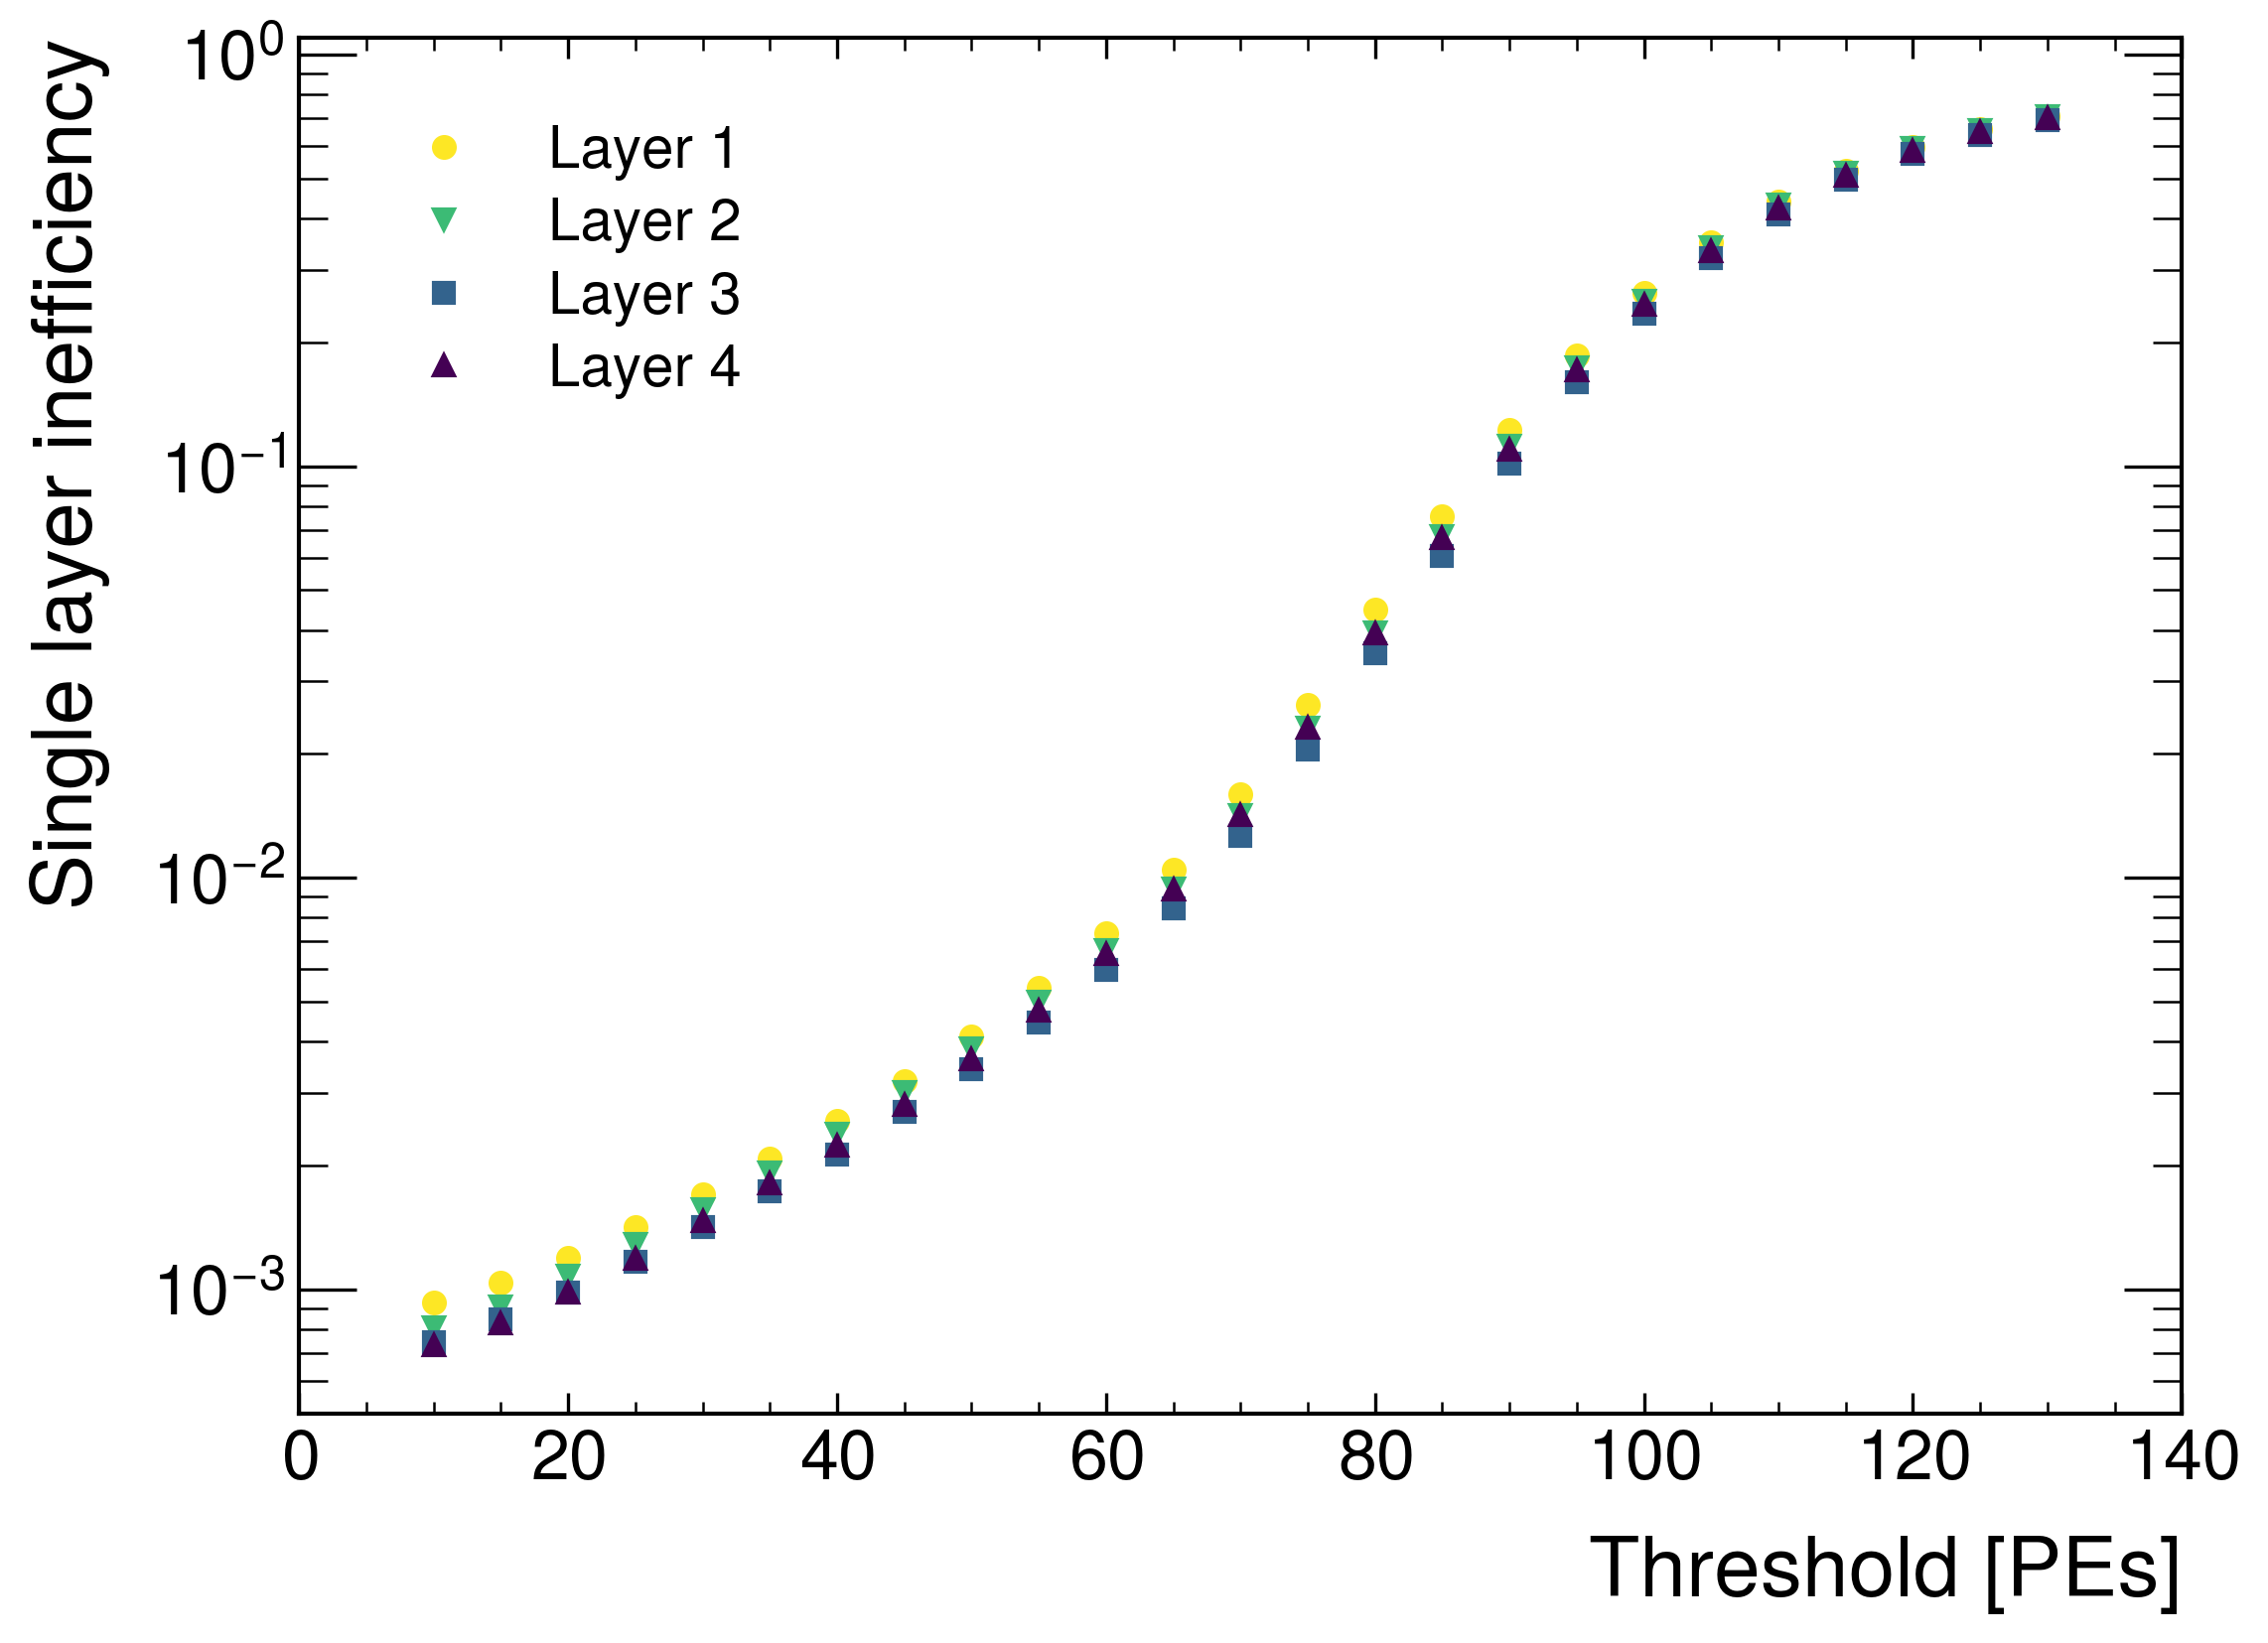

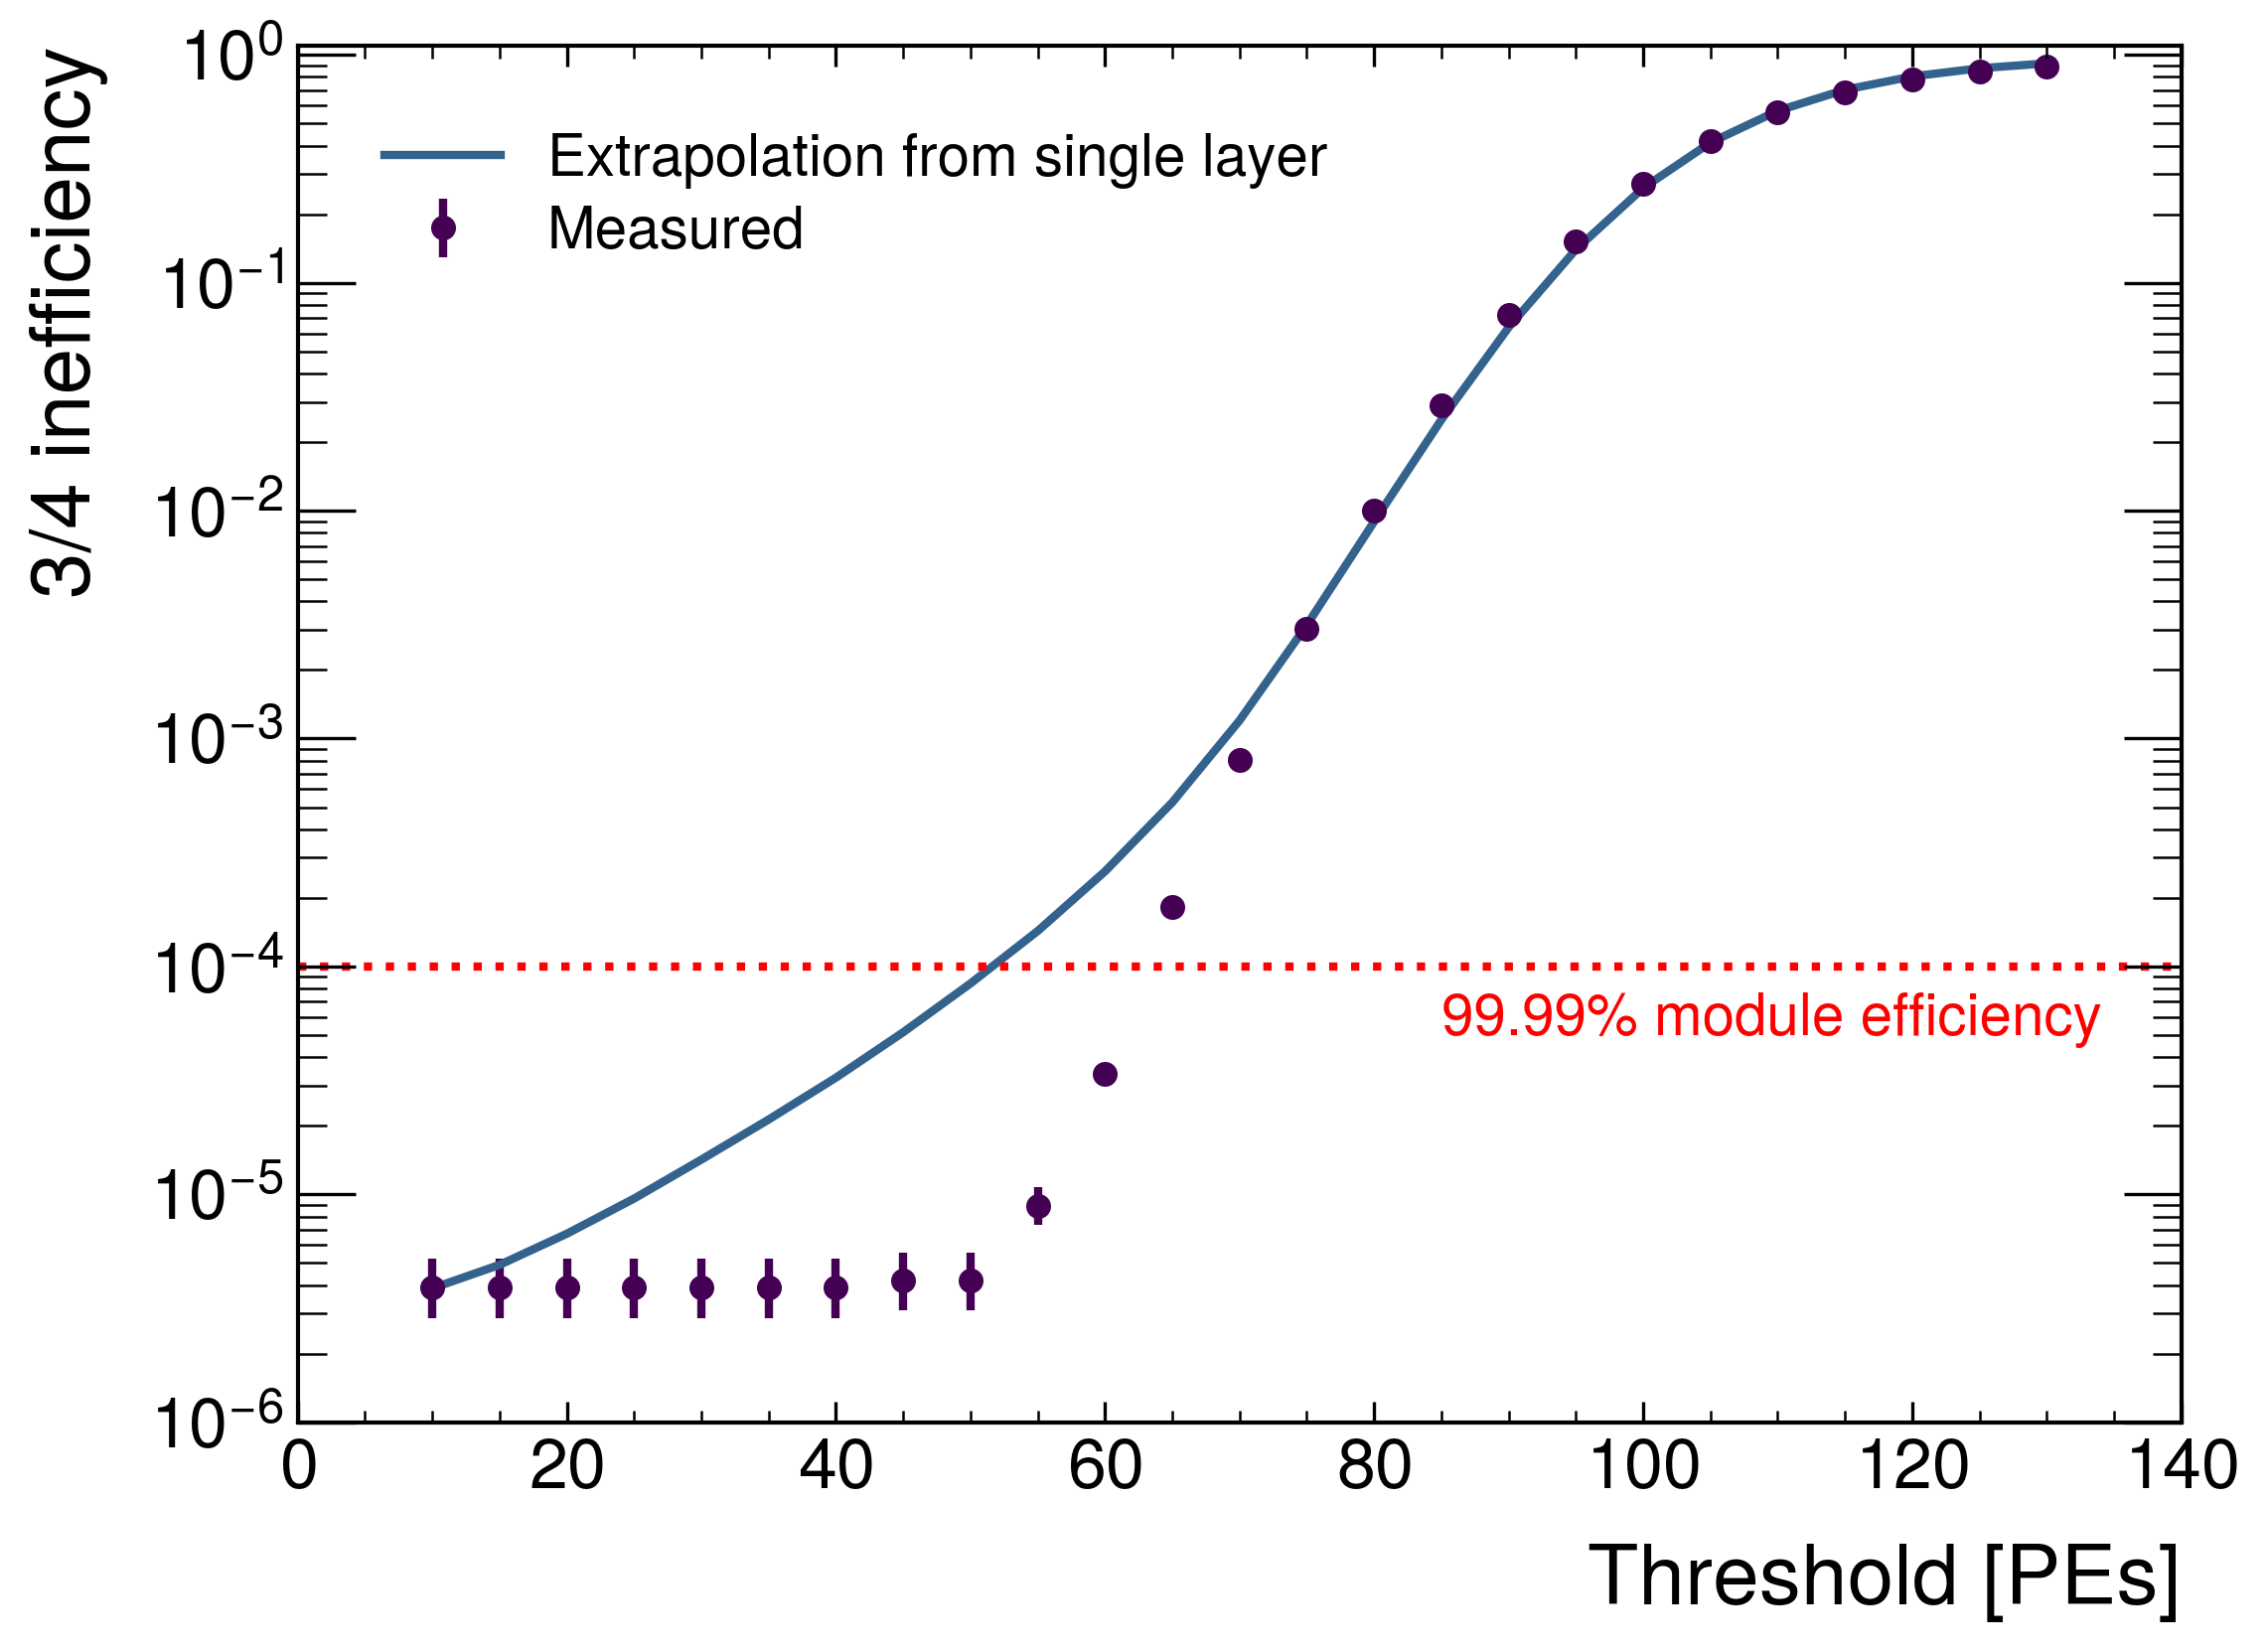

In [23]:
plt.rcParams['figure.dpi']=300

fig, ax = plt.subplots()

ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_layer0_data, fmt='o', color='#FDE725FF', label="Layer 1", markersize=5)
ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_layer1_data, fmt='v', color='#3CBB75FF', label="Layer 2", markersize=5)
ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_layer2_data, fmt='s', color='#33638DFF', label="Layer 3", markersize=5)
ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_layer3_data, fmt='^', color='#440154FF', label="Layer 4", markersize=5)

plt.legend()
ax.set_ylim(0.0005, 1.1)
ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('Single layer inefficiency')

fig.savefig('/exp/mu2e/data/users/thoroho/single-layer-efficiency_data.pdf',dpi=300)

plt.show()


fig, ax = plt.subplots()

ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_3of4_data, yerr=error_3of4_data, fmt='o', color='#440154FF', label='Measured', markersize=5)
ax.plot(np.linspace(10, 130, 25, endpoint=True), ineff_extrapolated_data, '-', color='#33638DFF', label='Extrapolation from single layer')

plt.axhline(y=0.0001, c='r', linestyle='dotted')
plt.text(85, 0.00005, '99.99% module efficiency', c='r') 

plt.legend()

ax.set_ylim(0.000001, 1.1)

ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('3/4 inefficiency')

fig.savefig('/exp/mu2e/data/users/thoroho/3of4_efficiency_data.pdf',dpi=300)

plt.show()

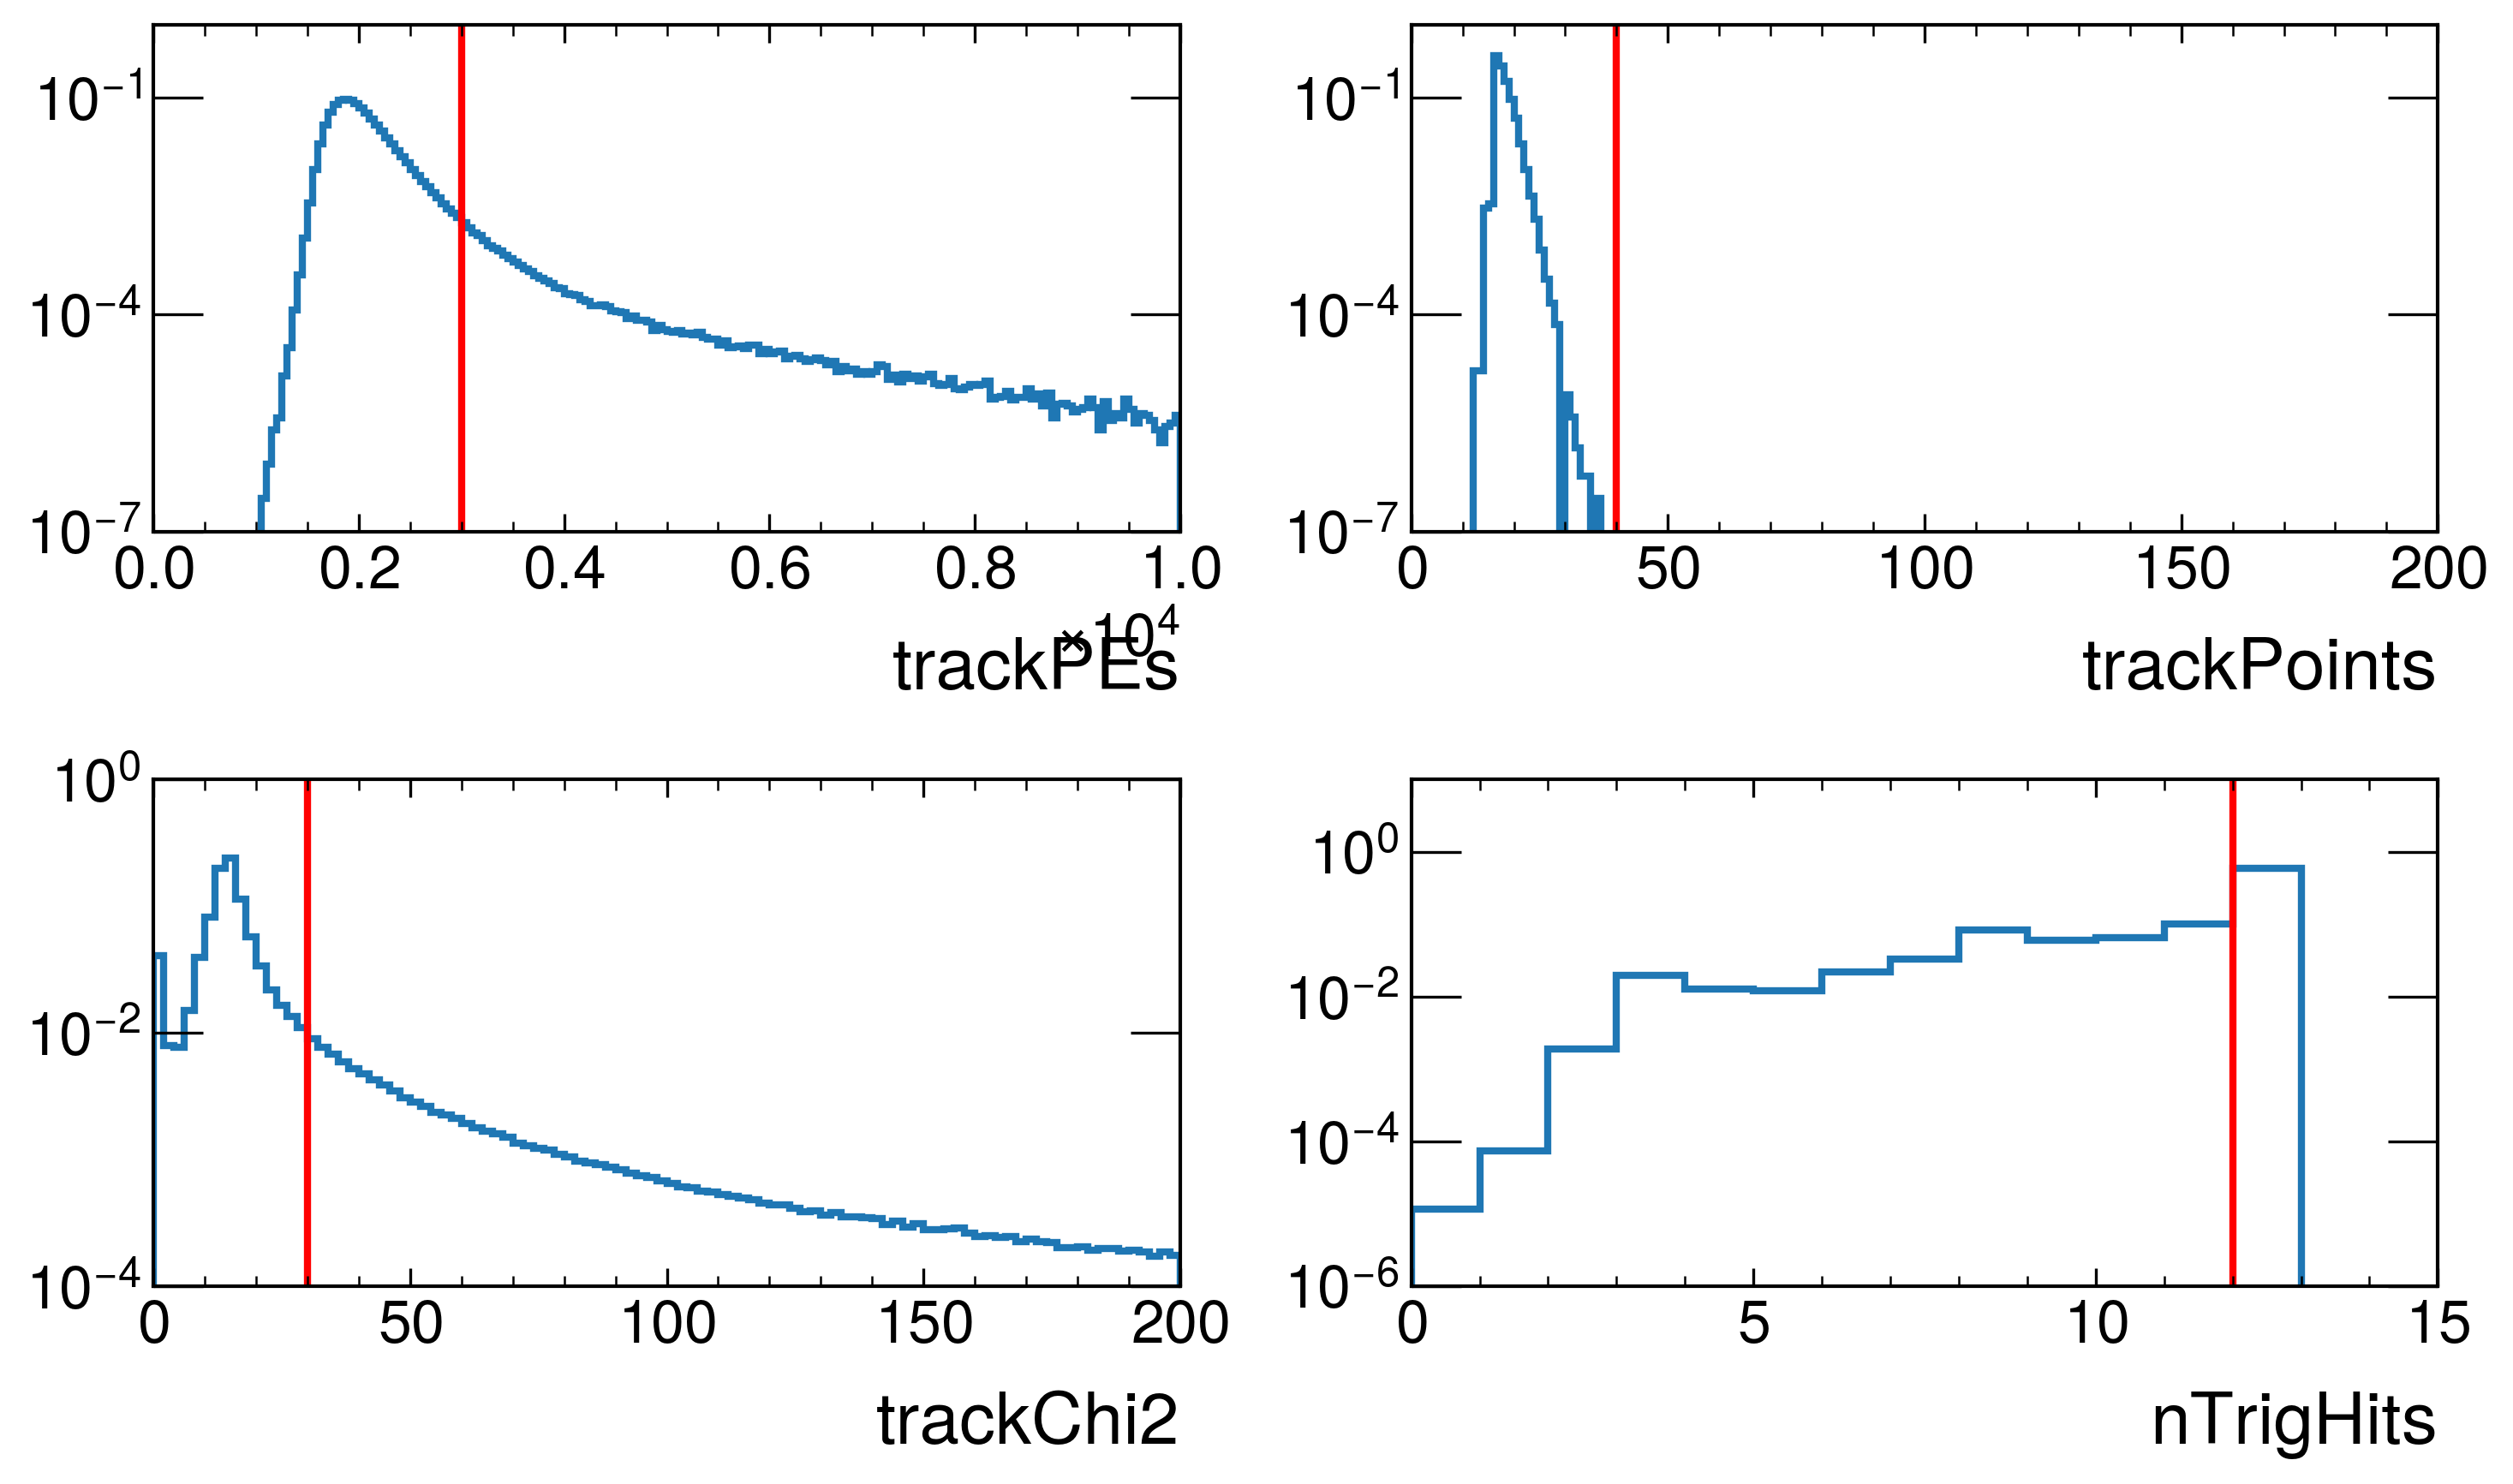

In [17]:
hTrackPEsDataNorm = hTrackPEsData/hTrackPEsData.sum()
hTrackPointsDataNorm = hTrackPointsData/hTrackPointsData.sum()
hTrackChi2DataNorm = hTrackChi2Data/hTrackChi2Data.sum()
hTrigHitsDataNorm = hTrigHitsData/hTrigHitsData.sum()

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2)
hTrackPEsDataNorm.plot1d(linewidth=2.0, ax=ax0)
hTrackPointsDataNorm.plot1d(linewidth=2.0, ax=ax1)
hTrackChi2DataNorm.plot1d(linewidth=2.0, ax=ax2)
hTrigHitsDataNorm.plot1d(linewidth=2.0, ax=ax3)

ax0.axvline(x=3000, ymin=0, ymax=1, color='r')
ax1.axvline(x=40, ymin=0, ymax=1, color='r')
ax2.axvline(x=30, ymin=0, ymax=1, color='r')
ax3.axvline(x=12, ymin=0, ymax=1, color='r')

#ax.set_xlabel('PEs in layer')
ax0.set_yscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')

#ax.set_xlim(1,300)
#ax.set_ylim(7e-5, 0.2)

fig.set_figheight(6)
fig.set_figwidth(10)
fig.tight_layout()

plt.show()

In [ ]:
# what if we don't use defining modules?
# comparison of single layer efficiency with and without defining module cuts
thresh = np.linspace(10, 130, 25, endpoint=True)
pass_2_data_is = np.zeros_like(thresh)
pass_3_data_is = np.zeros_like(thresh)
nTrig_data_is = np.zeros_like(thresh)

for i in range(len(ar_list_data)):
    ar = ar_list_data[i]

    ar = ar[(ar["PEsTestLayer1"]>10)&(ar["PEsTestLayer4"]>10)]
    
    for j in range(len(thresh)):
        ## testing module layers ##
        FEB1_1 = (ar["PEsTestLayer2"]>thresh[j])
        FEB2_0 = (ar["PEsTestLayer3"]>thresh[j])

        pass_2_data_is[j] += ak.count(ar[FEB1_1]["eventNumber"])
        pass_3_data_is[j] += ak.count(ar[FEB2_0]["eventNumber"])
        nTrig_data_is[j] += ak.count(ar["eventNumber"])

In [13]:
ineff_layer1_data_is = np.zeros_like(thresh)
ineff_layer2_data_is = np.zeros_like(thresh)

for i in range(len(thresh)):
    ineff_layer1_data_is[i] = 1 - pass_2_data_is[i]/nTrig_data_is[i]
    ineff_layer2_data_is[i] = 1 - pass_3_data_is[i]/nTrig_data_is[i]

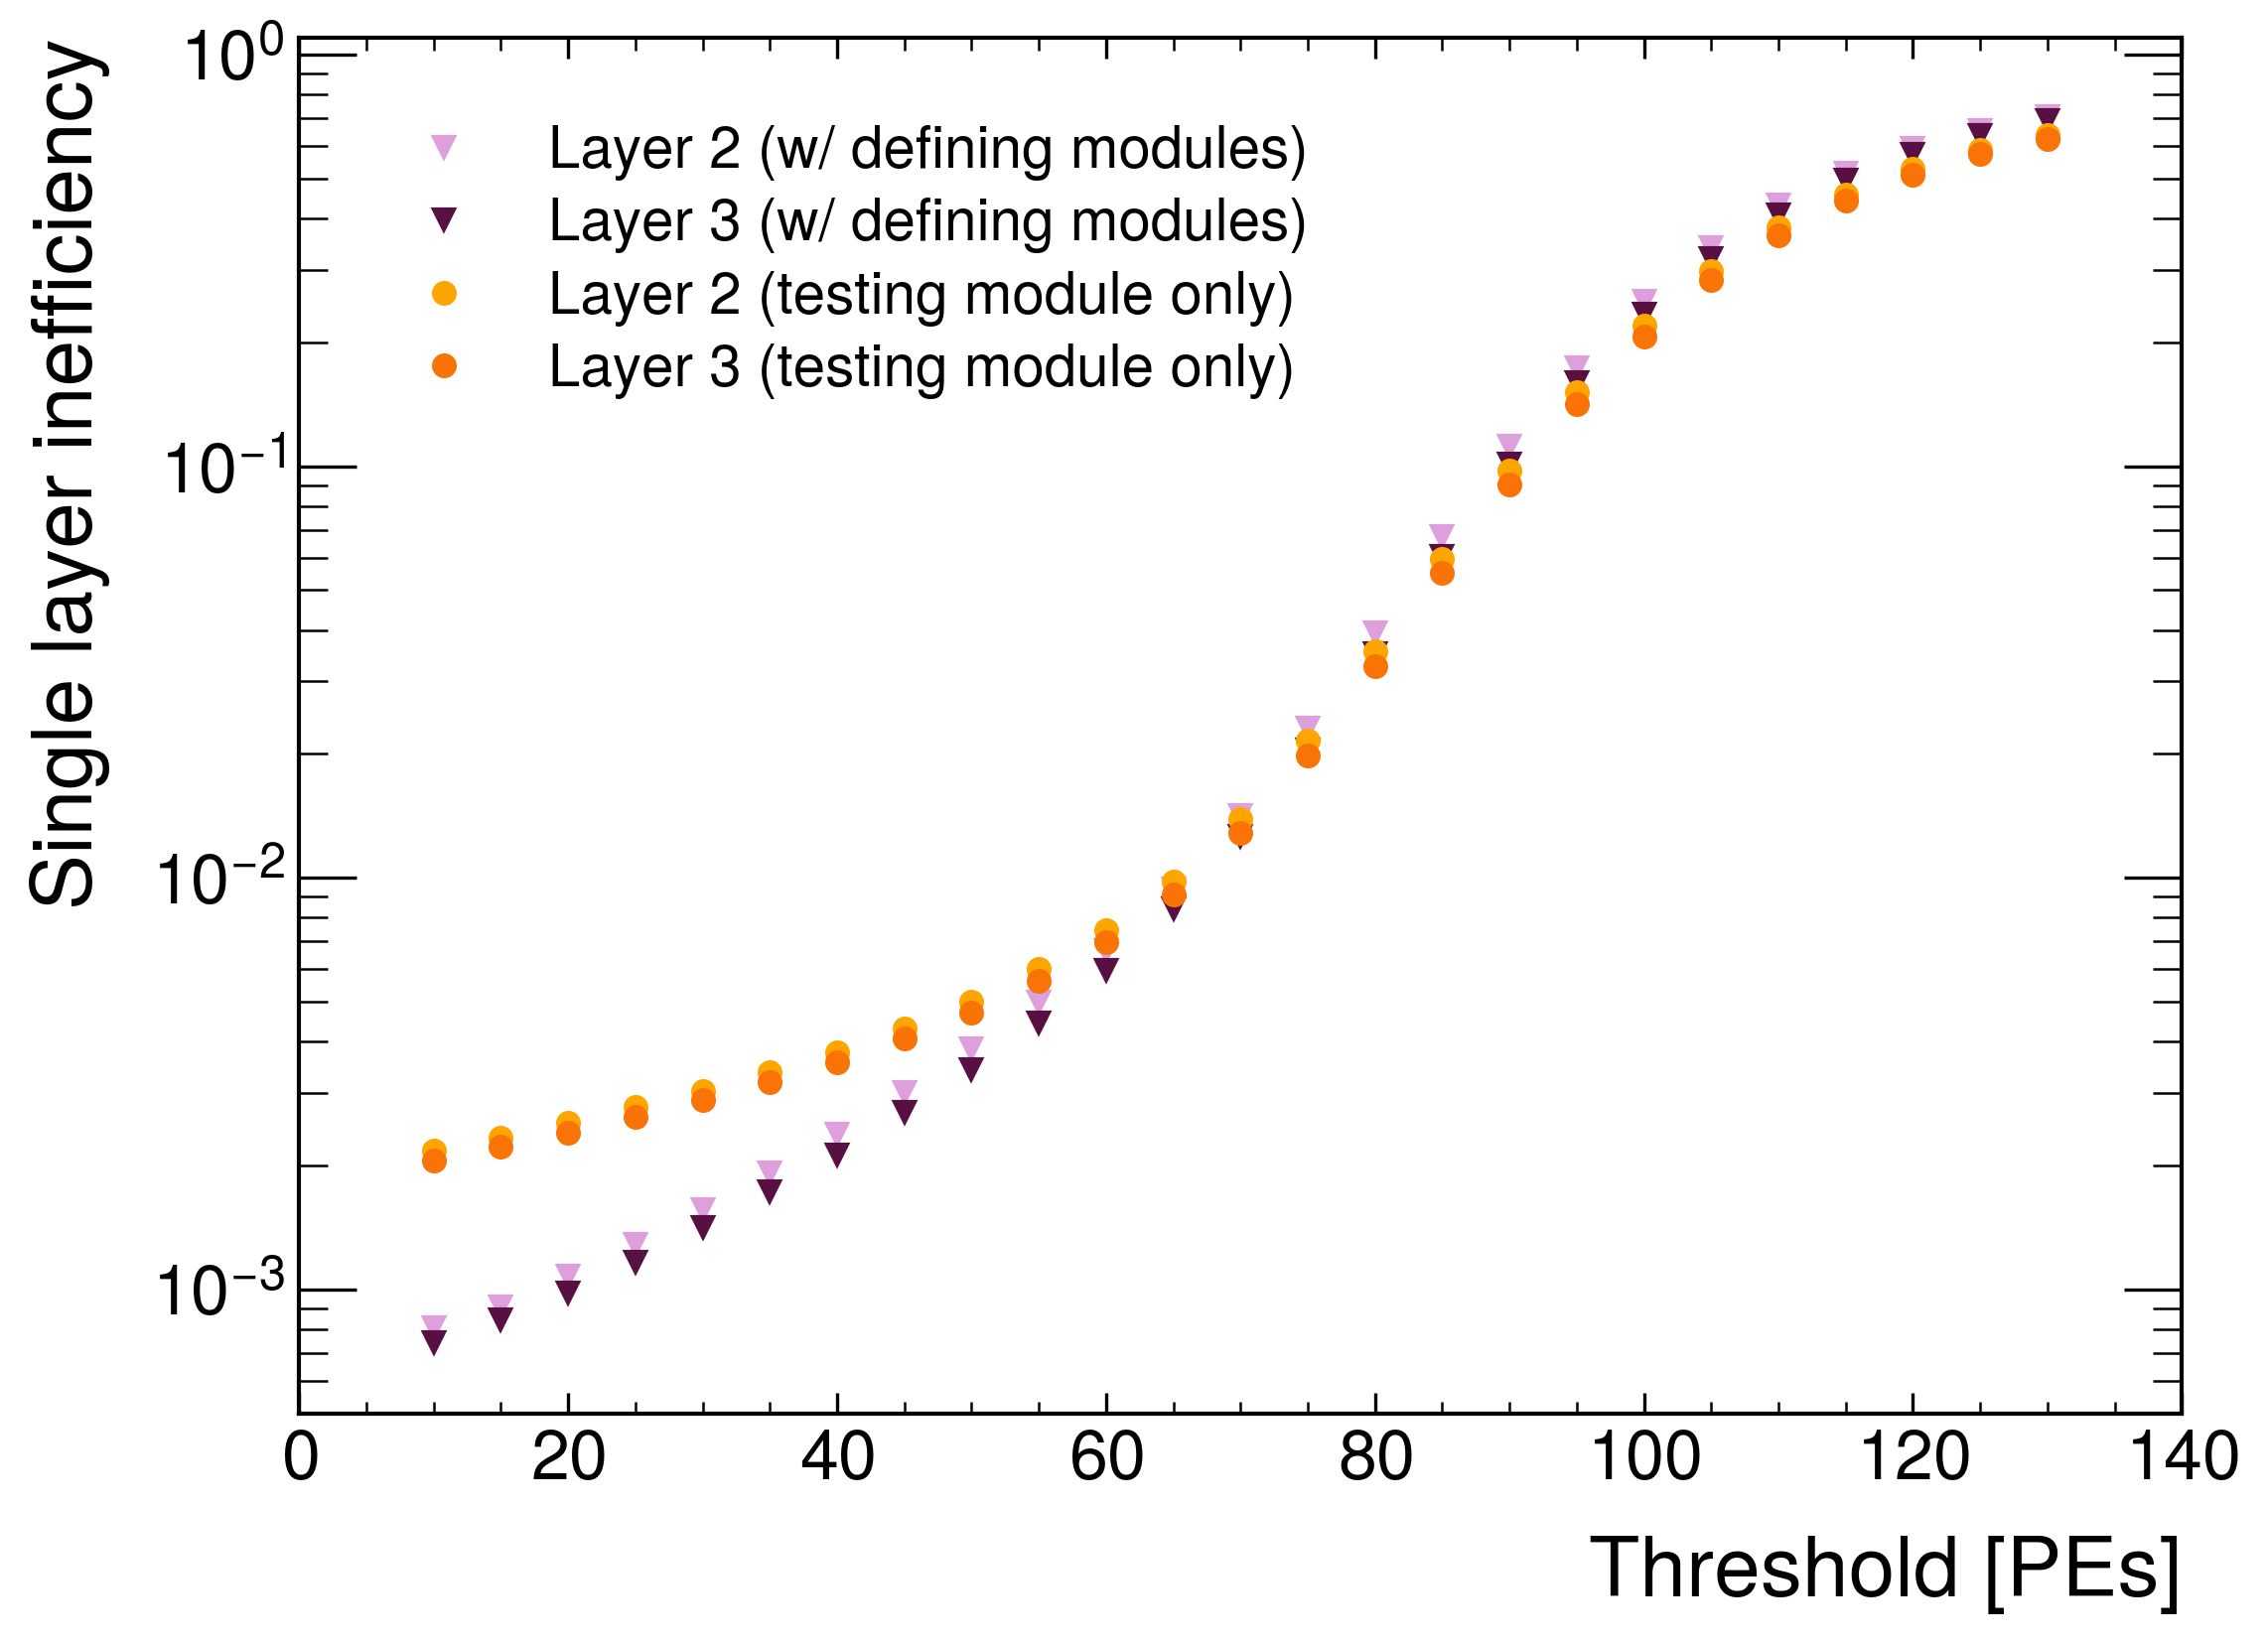

In [20]:
fig, ax = plt.subplots()

ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_layer1_data, fmt='v', color='#DDA0DD', label="Layer 2 (w/ defining modules)", markersize=5)
ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_layer2_data, fmt='v', color='#580F41', label="Layer 3 (w/ defining modules)", markersize=5)

ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_layer1_data_is, fmt='o', color='#FFA500', label="Layer 2 (testing module only)", markersize=5)
ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_layer2_data_is, fmt='o', color='#F97306', label="Layer 3 (testing module only)", markersize=5)

plt.legend()
ax.set_ylim(0.0005, 1.1)
ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('Single layer inefficiency')

fig.savefig('/exp/mu2e/data/users/thoroho/single-layer-efficiency_data_comparison.pdf',dpi=300)

plt.show()

In [26]:
processor = wideband.DataProcessor(treename='CrvWidebandTest/run', runlist=[1738], userunlist=False, remove=False)
filelist = processor.getFilelist(DATASET_MC_v30, root_schema=True)
filelist = ["{}{}".format(i, ":CrvWidebandTest/run") for i in filelist]
PEs = 'PEs'

# List of variable to import
varlist=[PEs, 'trackIntercept', 'trackChi2', 'trackPoints', 'trackPEs', 'trackSlope',
         'runNumber', 'subrunNumber', 'spillNumber', 'eventNumber', 'coincidencePDGid']
varlist_keep = ['runNumber', 'subrunNumber', 'spillNumber', 'eventNumber',
                'nTrigHits',
                'trackIntercept', 'trackChi2', 'trackPoints', 'trackPEs', 'trackSlope', 'trackChi2NDF',
                'PEsTestLayer1', 'PEsTestLayer2', 'PEsTestLayer3', 'PEsTestLayer4']
varlist.append('coincidencePDGid')

ar_list_MC = []
ar_skim_list_MC = []

hTrackSlopeMC = Hist(hist.axis.Regular(bins=80, start=-2, stop=2, name="trackSlope", flow=False))
hTrackPEsMC = Hist(hist.axis.Regular(bins=200, start=0, stop=10000, name="trackPEs", flow=False))
hTrackPointsMC = Hist(hist.axis.Regular(bins=200, start=0, stop=200, name="trackPoints", flow=False))
hTrackChi2MC = Hist(hist.axis.Regular(bins=100, start=0, stop=200, name="trackChi2", flow=False))
hTrigHitsMC = Hist(hist.axis.Regular(bins=13, start=0, stop=13, name="nTrigHits", flow=False))

hPEHitsMC = Hist(hist.axis.Regular(bins=150, start=0, stop=300, name="PEsPerHit", flow=False))

hTrackSlopeMCUncut = Hist(hist.axis.Regular(bins=80, start=-2, stop=2, name="trackSlope", flow=False))
hTrackPEsMCUncut = Hist(hist.axis.Regular(bins=200, start=0, stop=10000, name="trackPEs", flow=False))
hTrackPointsMCUncut = Hist(hist.axis.Regular(bins=200, start=0, stop=200, name="trackPoints", flow=False))
hTrackChi2MCUncut = Hist(hist.axis.Regular(bins=100, start=0, stop=200, name="trackChi2", flow=False))
hTrigHitsMCUncut = Hist(hist.axis.Regular(bins=13, start=0, stop=13, name="nTrigHits", flow=False))

hTrackPEsMuons = Hist(hist.axis.Regular(bins=200, start=0, stop=10000, name="trackPEs", flow=False))
hTrackPointsMuons = Hist(hist.axis.Regular(bins=200, start=0, stop=200, name="trackPoints", flow=False))
hTrackChi2Muons = Hist(hist.axis.Regular(bins=200, start=0, stop=5, name="trackChi2", flow=False))
hTrigHitsMuons = Hist(hist.axis.Regular(bins=13, start=0, stop=13, name="nTrigHits", flow=False))

hTrackPEsNotMuons = Hist(hist.axis.Regular(bins=200, start=0, stop=10000, name="trackPEs", flow=False))
hTrackPointsNotMuons = Hist(hist.axis.Regular(bins=200, start=0, stop=200, name="trackPoints", flow=False))
hTrackChi2NotMuons = Hist(hist.axis.Regular(bins=200, start=0, stop=5, name="trackChi2", flow=False))
hTrigHitsNotMuons = Hist(hist.axis.Regular(bins=13, start=0, stop=13, name="nTrigHits", flow=False))

allevents = 0
cutevents = 0

allfiles = 0
filesloaded = 0

for idx, filename in enumerate(filelist):
    if idx%200 == 0:
        print("Processing file: %s"%filename)
    try:
        allfiles += 1
        with uproot.open(filename) as file:
            for ar in file.iterate(step_size="10MB", 
                                           filter_name=varlist, 
                                           report=False, library='ak'):
                
                allevents += len(ar["eventNumber"])                         
    
                ar[PEs] = ak.where(ar[PEs] >= 5, ar[PEs], 0)
    
                FEB0_0 = (ak.sum(ar[PEs][:,0,0:32], axis=-1)>10)
                FEB0_1 = (ak.sum(ar[PEs][:,0,32:64], axis=-1)>10)
    
                FEB1_0 = (ak.sum(ar[PEs][:,1,0:32], axis=-1)>10) #0:32
                FEB1_1 = (ak.sum(ar[PEs][:,1,32:64], axis=-1)>10)
    
                FEB4_0 = (ak.sum(ar[PEs][:,4,0:32], axis=-1)>10)
                FEB4_1 = (ak.sum(ar[PEs][:,4,32:64], axis=-1)>10)
    
                FEB5_0 = (ak.sum(ar[PEs][:,5,0:32], axis=-1)>10)
                FEB5_1 = (ak.sum(ar[PEs][:,5,32:64], axis=-1)>10)
    
                FEB6_0 = (ak.sum(ar[PEs][:,6,0:32], axis=-1)>10)
                FEB6_1 = (ak.sum(ar[PEs][:,6,32:64], axis=-1)>10)
    
                FEB7_0 = (ak.sum(ar[PEs][:,7,0:32], axis=-1)>10)
                FEB7_1 = (ak.sum(ar[PEs][:,7,32:64], axis=-1)>10)
    
                nTrigHits = ak.values_astype(FEB0_0, "int") + ak.values_astype(FEB0_1, "int") + \
                            ak.values_astype(FEB1_0, "int") + ak.values_astype(FEB1_1, "int") + \
                            ak.values_astype(FEB4_0, "int") + ak.values_astype(FEB4_1, "int") + \
                            ak.values_astype(FEB5_0, "int") + ak.values_astype(FEB5_1, "int") + \
                            ak.values_astype(FEB6_0, "int") + ak.values_astype(FEB6_1, "int") + \
                            ak.values_astype(FEB7_0, "int") + ak.values_astype(FEB7_1, "int")
                ar["nTrigHits"] = nTrigHits
    
                ar["PEsTestLayer4"] = ak.sum(ar[PEs][:,2,0:32], axis=-1)
                ar["PEsTestLayer3"] = ak.sum(ar[PEs][:,2,32:64], axis=-1)
                ar["PEsTestLayer2"] = ak.sum(ar[PEs][:,3,0:32], axis=-1)
                ar["PEsTestLayer1"] = ak.sum(ar[PEs][:,3,32:64], axis=-1)
    
                ar['trackIntercept'] = ar['trackIntercept'][:,0] - 39950.0
    
                ar['trackChi2NDF'] = ak.where(ar['trackPoints'][:,0] > 2, ar['trackChi2'][:,0] * ar['trackPoints'][:,0] / ((ar['trackPoints'][:,0] - 2)*(51.3**2)/12), -999)
                ar['trackPEs'] = ar['trackPEs'][:,0]
                ar['trackPoints'] = ar['trackPoints'][:,0]

                ar_list_MC.append(ar[varlist_keep])
    
                ar_cleanup = ar[(nTrigHits >=12) &
                                (ar["trackPEs"] < 3000) & 
                                (ar["trackPoints"] < 40) &
                                (ar["trackChi2NDF"] < 2) & (ar["trackChi2NDF"] > 0)]
    
                ar_skim_list_MC.append(ar_cleanup[varlist_keep])
                cutevents += len(ar_cleanup["eventNumber"])
    
                # fill N - 1 feature histograms
                ar_cleanup = ar[(nTrigHits >= 12) & 
                                (ar["trackPoints"] < 40) &
                                (ar["trackChi2NDF"] < 2) & (ar["trackChi2NDF"] > 0)]
                ar_muons = ar_cleanup[(abs(ar_cleanup['coincidencePDGid'][:,2])==13)]
                ar_notmuons = ar_cleanup[(abs(ar_cleanup['coincidencePDGid'][:,2])!=13)]
                hTrackPEsMC.fill(ar_cleanup["trackPEs"])
                hTrackPEsMuons.fill(ar_muons["trackPEs"])
                hTrackPEsNotMuons.fill(ar_notmuons["trackPEs"])
                hTrackPEsMCUncut.fill(ar["trackPEs"])
    
                ar_cleanup = ar[(nTrigHits >= 12) & 
                                (ar["trackPEs"] < 3000) &
                                (ar["trackChi2NDF"] < 2) & (ar["trackChi2NDF"] > 0)]
                ar_muons = ar_cleanup[(abs(ar_cleanup['coincidencePDGid'][:,2])==13)]
                ar_notmuons = ar_cleanup[(abs(ar_cleanup['coincidencePDGid'][:,2])!=13)]
                hTrackPointsMC.fill(ar_cleanup["trackPoints"])
                hTrackPointsMuons.fill(ar_muons["trackPoints"])
                hTrackPointsNotMuons.fill(ar_notmuons["trackPoints"])
                hTrackPointsMCUncut.fill(ar["trackPoints"])
    
                ar_cleanup = ar[(nTrigHits >= 12) & 
                                (ar["trackPoints"] < 40) &
                                (ar["trackPEs"] < 3000)]
                ar_muons = ar_cleanup[(abs(ar_cleanup['coincidencePDGid'][:,2])==13)]
                ar_notmuons = ar_cleanup[(abs(ar_cleanup['coincidencePDGid'][:,2])!=13)]
                hTrackChi2MC.fill(ar_cleanup["trackChi2NDF"])
                hTrackChi2Muons.fill(ar_muons["trackChi2NDF"])
                hTrackChi2NotMuons.fill(ar_notmuons["trackChi2NDF"])
                hTrackChi2MCUncut.fill(ar["trackChi2NDF"])
    
                ar_cleanup = ar[(ar["trackPoints"] < 40) & 
                                (ar["trackPEs"] < 3000) &
                                (ar["trackChi2NDF"] < 2) & (ar["trackChi2NDF"] > 0)]
                ar_muons = ar_cleanup[(abs(ar_cleanup['coincidencePDGid'][:,2])==13)]
                ar_notmuons = ar_cleanup[(abs(ar_cleanup['coincidencePDGid'][:,2])!=13)]
                hTrigHitsMC.fill(ar_cleanup["nTrigHits"])
                hTrigHitsMuons.fill(ar_muons["nTrigHits"])
                hTrigHitsNotMuons.fill(ar_notmuons["nTrigHits"])
                hTrigHitsMCUncut.fill(ar["nTrigHits"])
    
                filesloaded += 1
        
    except:
        continue


print("{0} files loaded out of {1}".format(filesloaded, allfiles))
print("Total events: {0}".format(allevents))
print("Events after cuts: {0}".format(cutevents))

Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v25/MDC2020an/root/a1/3e/nts.mu2e.WidebandCRV_v25.MDC2020an.103001_00000000.root:CrvWidebandTest/run


/home/thoroho/.conda/envs/Mu2eCRV/lib/python3.10/site-packages/awkward/_backends.py:57: RuntimeWarning: divide by zero encountered in divide
  return getattr(ufunc, method)(*args, **kwargs)
/home/thoroho/.conda/envs/Mu2eCRV/lib/python3.10/site-packages/awkward/_backends.py:57: RuntimeWarning: invalid value encountered in multiply
  return getattr(ufunc, method)(*args, **kwargs)
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v25/MDC2020an/root/50/07/nts.mu2e.WidebandCRV_v25.MDC2020an.103001_00000200.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v25/MDC2020an/root/de/bd/nts.mu2e.WidebandCRV_v25.MDC2020an.103001_00000400.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v25/MDC2020an/root/84/49/nts.mu2e.WidebandCRV_v25.MDC2020an.103001_00000600.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v25/MDC2020an/root/ab/8e/nts.mu2e.WidebandCRV_v25.MDC2020an.103001_00000800.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v25/MDC2020an/root/1f/5e/nts.mu2e.WidebandCRV_v25.MDC2020an.103001_00001000.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/ph

In [26]:
# save MC data for later
combined_ar = ak.concatenate(ar_skim_list_MC, axis=0)
with open("/exp/mu2e/data/users/thoroho/efficiency/MC_arr.pkl", "wb") as f:
    pickle.dump(combined_ar, f)
combined_ar = ak.concatenate(ar_list_MC, axis=0)
with open("/exp/mu2e/data/users/thoroho/efficiency/MC_arr_unskimmed.pkl", "wb") as f:
    pickle.dump(combined_ar, f)

In [ ]:
thresh = np.linspace(10, 130, 25, endpoint=True)
pass_1_MC = np.zeros_like(thresh)
pass_2_MC = np.zeros_like(thresh)
pass_3_MC = np.zeros_like(thresh)
pass_4_MC = np.zeros_like(thresh)
pass_3of4_MC = np.zeros_like(thresh)
nTrig_MC = np.zeros_like(thresh)

counter = 0

for i in range(len(ar_skim_list_MC)):
    ar_clean = ar_skim_list_MC[i]

    for j in range(len(thresh)):
        ## testing module layers ##
        FEB1_0 = (ar_clean["PEsTestLayer1"]>thresh[j])
        FEB1_1 = (ar_clean["PEsTestLayer2"]>thresh[j])
        FEB2_0 = (ar_clean["PEsTestLayer3"]>thresh[j])
        FEB2_1 = (ar_clean["PEsTestLayer4"]>thresh[j])

        nHits_test = ak.values_astype(FEB1_0, "int") + ak.values_astype(FEB1_1, "int") + \
                     ak.values_astype(FEB2_0, "int") + ak.values_astype(FEB2_1, "int")

        pass_1_MC[j] += ak.count(ar_clean[FEB1_0]["eventNumber"])
        pass_2_MC[j] += ak.count(ar_clean[FEB1_1]["eventNumber"])
        pass_3_MC[j] += ak.count(ar_clean[FEB2_0]["eventNumber"])
        pass_4_MC[j] += ak.count(ar_clean[FEB2_1]["eventNumber"])
        pass_3of4_MC[j] += ak.count(ar_clean[(nHits_test >= 3)]["eventNumber"])
        nTrig_MC[j] += ak.count(ar_clean["eventNumber"])

        # find inefficient MC events
        if thresh[j] == 10:
            ar_fail = ar_clean[(nHits_test < 3)]
            for j in range(len(ar_fail)):
                print(ar_fail["runNumber"][j], ar_fail["subrunNumber"][j], ar_fail["spillNumber"][j], ar_fail["eventNumber"][j])
                counter += 1
                if counter > 5:
                    break

In [17]:
with open("/exp/mu2e/data/users/thoroho/efficiency/MCv30_arr.pkl", "rb") as f:
    ar_skim_list_MC_loaded = pickle.load(f)

thresh = np.linspace(10, 130, 25, endpoint=True)
pass_1_MC = np.zeros_like(thresh)
pass_2_MC = np.zeros_like(thresh)
pass_3_MC = np.zeros_like(thresh)
pass_4_MC = np.zeros_like(thresh)
pass_3of4_MC = np.zeros_like(thresh)
nTrig_MC = np.zeros_like(thresh)

ar_clean = ar_skim_list_MC_loaded

for j in range(len(thresh)):
    ## testing module layers ##
    FEB1_0 = (ar_clean["PEsTestLayer1"]>thresh[j])
    FEB1_1 = (ar_clean["PEsTestLayer2"]>thresh[j])
    FEB2_0 = (ar_clean["PEsTestLayer3"]>thresh[j])
    FEB2_1 = (ar_clean["PEsTestLayer4"]>thresh[j])

    nHits_test = ak.values_astype(FEB1_0, "int") + ak.values_astype(FEB1_1, "int") + \
                 ak.values_astype(FEB2_0, "int") + ak.values_astype(FEB2_1, "int")

    pass_1_MC[j] += ak.count(ar_clean[FEB1_0]["eventNumber"])
    pass_2_MC[j] += ak.count(ar_clean[FEB1_1]["eventNumber"])
    pass_3_MC[j] += ak.count(ar_clean[FEB2_0]["eventNumber"])
    pass_4_MC[j] += ak.count(ar_clean[FEB2_1]["eventNumber"])
    pass_3of4_MC[j] += ak.count(ar_clean[(nHits_test >= 3)]["eventNumber"])
    nTrig_MC[j] += ak.count(ar_clean["eventNumber"])

In [29]:
ineff_layer0_MC = np.zeros_like(thresh)
ineff_layer1_MC = np.zeros_like(thresh)
ineff_layer2_MC = np.zeros_like(thresh)
ineff_layer3_MC = np.zeros_like(thresh)

ineff_extrapolated_MC = np.zeros_like(thresh)

for i in range(len(thresh)):
    ineff_0 = 1 - pass_1_MC[i]/nTrig_MC[i]
    ineff_1 = 1 - pass_2_MC[i]/nTrig_MC[i]
    ineff_2 = 1 - pass_3_MC[i]/nTrig_MC[i]
    ineff_3 = 1 - pass_4_MC[i]/nTrig_MC[i]

    eff_avg = (pass_1_MC[i] + pass_2_MC[i] + \
               pass_3_MC[i] + pass_4_MC[i])/(4*nTrig_MC[i])

    eff_3of4 = 4*eff_avg**3 - 3*eff_avg**4

    ineff_layer0_MC[i] = ineff_0
    ineff_layer1_MC[i] = ineff_1
    ineff_layer2_MC[i] = ineff_2
    ineff_layer3_MC[i] = ineff_3
    ineff_extrapolated_MC[i] = 1 - eff_3of4
    
ineff_3of4_MC = np.ones_like(thresh) - np.divide(pass_3of4_MC, nTrig_MC)
error_3of4_MC = np.zeros((2, len(thresh)))
for i in range(len(thresh)):
    result = stats.binomtest(int(pass_3of4_MC[i]), int(nTrig_MC[i]), 0.5)
    error_3of4_MC[1][i] = (1 - result.proportion_ci(0.68).low) - ineff_3of4_MC[i]
    error_3of4_MC[0][i] = ineff_3of4_MC[i] - (1 - result.proportion_ci(0.68).high)

In [46]:
ineff_3of4_MC_v25 = [3.87915275e-06, 4.04078412e-06, 4.04078412e-06, 4.20241548e-06,
                     4.36404685e-06, 4.36404685e-06, 4.36404685e-06, 4.36404685e-06,
                     4.84894094e-06, 1.05060387e-05, 5.51162954e-05, 2.82208363e-04,
                     1.13836970e-03, 3.81078269e-03, 1.11200763e-02, 2.91540958e-02,
                     6.81617245e-02, 1.39640286e-01, 2.46840026e-01, 3.79023449e-01,
                     5.15254122e-01, 6.36972560e-01, 7.34702804e-01, 8.07785557e-01,
                     8.59846373e-01]
error_3of4_MC_v25 = [[7.82499262e-07, 7.98849798e-07, 7.98849798e-07, 8.14872156e-07,
                      8.30585230e-07, 8.30585230e-07, 8.30585230e-07, 8.30585230e-07,
                      8.76033815e-07, 1.29313286e-06, 2.96723854e-06, 6.71541248e-06,
                      1.34821227e-05, 2.46345930e-05, 4.19274489e-05, 6.72678832e-05,
                      1.00771858e-04, 1.38601066e-04, 1.72425625e-04, 1.94024813e-04,
                      1.99893154e-04, 1.92358521e-04, 1.76629322e-04, 1.57670006e-04,
                      1.38929744e-04],
                     [9.59387791e-07, 9.75406295e-07, 9.75406295e-07, 9.91115270e-07,
                      1.00653336e-06, 1.00653336e-06, 1.00653336e-06, 1.00653336e-06,
                      1.05118602e-06, 1.46356286e-06, 3.13201902e-06, 6.87768607e-06,
                      1.36431542e-05, 2.47943308e-05, 4.20846224e-05, 6.74191496e-05,
                      1.00910538e-04, 1.38716766e-04, 1.72506897e-04, 1.94063648e-04,
                      1.99888257e-04, 1.92314551e-04, 1.76553976e-04, 1.57571193e-04,
                      1.38814210e-04]]

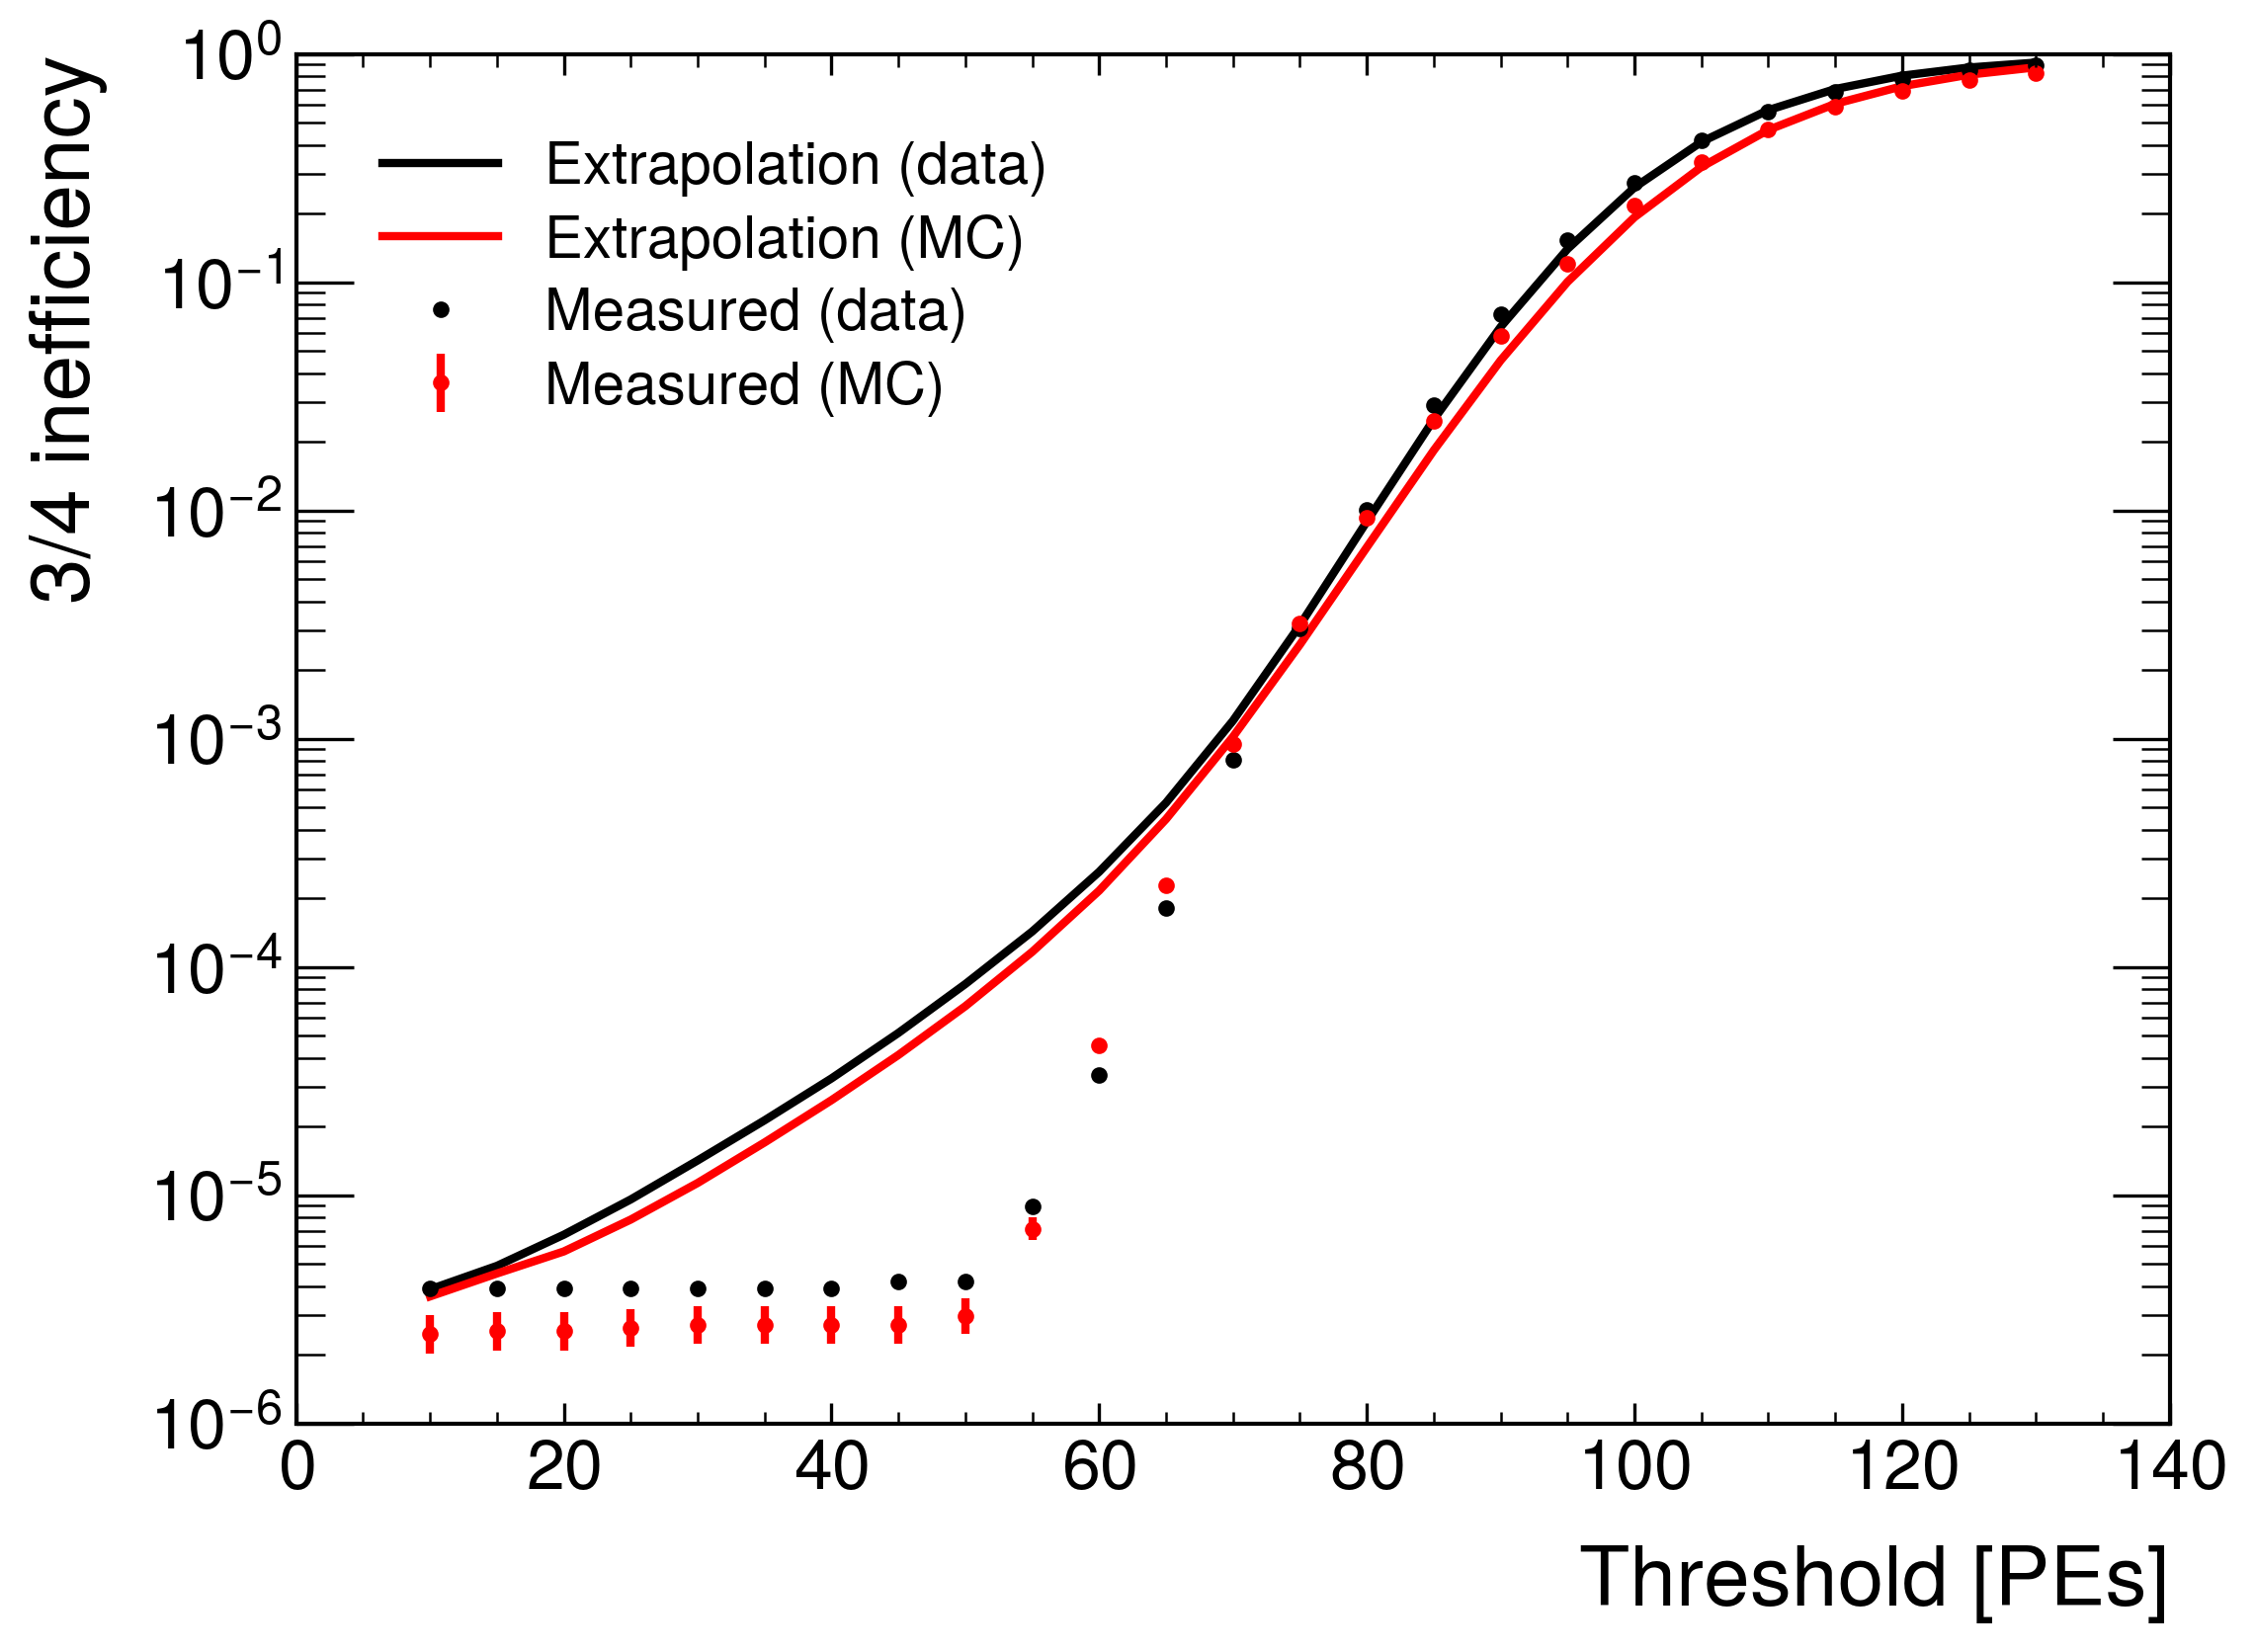

In [31]:
fig, ax = plt.subplots()

dataE = ax.plot(np.linspace(10, 130, 25, endpoint=True), ineff_extrapolated_data, '-', color='k', label='Extrapolation (data)')
dataM = ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_3of4_data, fmt='o', color='k', label='Measured (data)', markersize=3)

mcM = ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_3of4_MC, yerr=error_3of4_MC, fmt='o', color='r', label='Measured (MC)', markersize=3)
mcE = ax.plot(np.linspace(10, 130, 25, endpoint=True), ineff_extrapolated_MC, '-', color='r', label='Extrapolation (MC)')

plt.legend()

ax.set_ylim(0.000001, 1.)#1)

ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('3/4 inefficiency')

fig.savefig('/exp/mu2e/data/users/thoroho/efficiency_mc-vs-data.pdf',dpi=300)

plt.show()

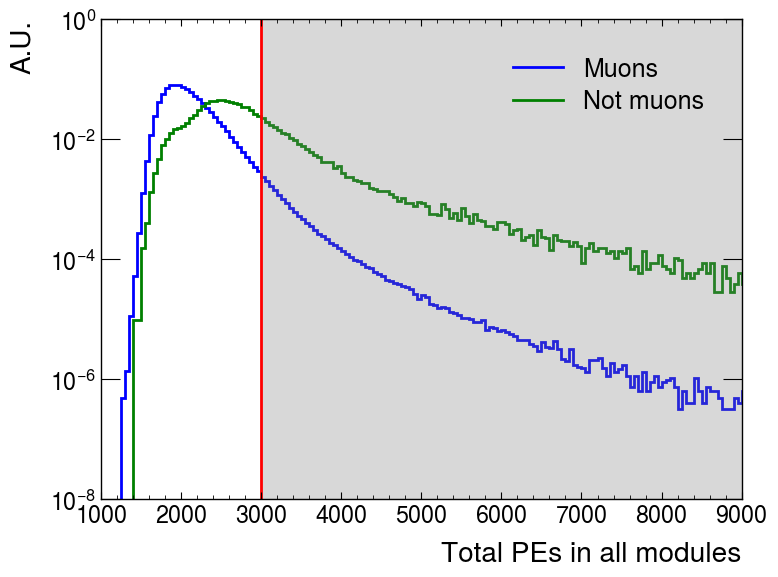

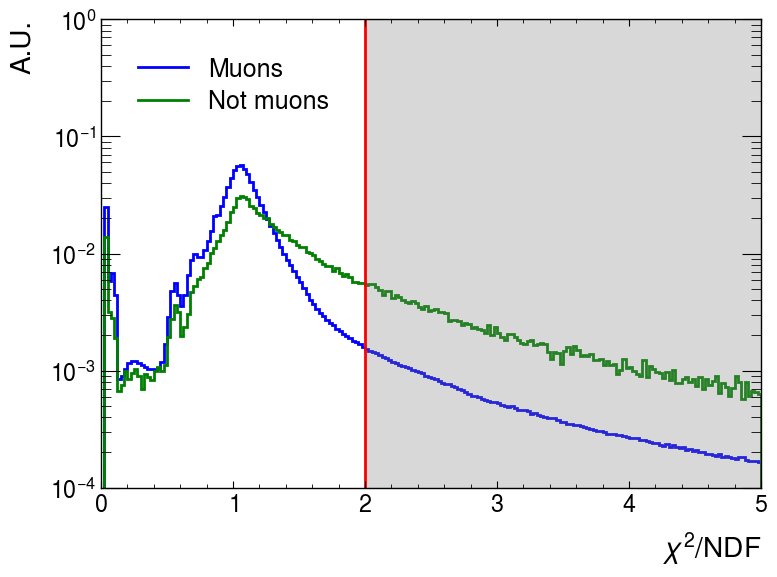

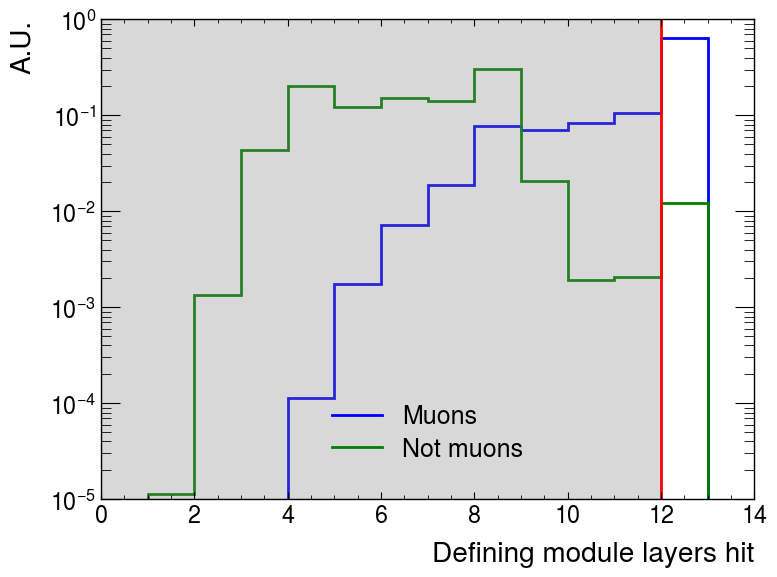

In [10]:
hTrackPEsMuonsNorm = hTrackPEsMuons/hTrackPEsMuons.sum()
hTrackPointsMuonsNorm = hTrackPointsMuons/hTrackPointsMuons.sum()
hTrackChi2MuonsNorm = hTrackChi2Muons/hTrackChi2Muons.sum()
hTrigHitsMuonsNorm = hTrigHitsMuons/hTrigHitsMuons.sum()

hTrackPEsNotMuonsNorm = hTrackPEsNotMuons/hTrackPEsNotMuons.sum()
hTrackPointsNotMuonsNorm = hTrackPointsNotMuons/hTrackPointsNotMuons.sum()
hTrackChi2NotMuonsNorm = hTrackChi2NotMuons/hTrackChi2NotMuons.sum()
hTrigHitsNotMuonsNorm = hTrigHitsNotMuons/hTrigHitsNotMuons.sum()

fig, ax = plt.subplots()
hTrackPEsMuonsNorm.plot1d(linewidth=2.0, color='blue', label='Muons')
hTrackPEsNotMuonsNorm.plot1d(linewidth=2.0, color='green', label='Not muons')
ax.axvline(x=3000, ymin=0, ymax=1, color='r')
ax.axvspan(3000, 10000, alpha=0.3, color='grey')
ax.set_yscale('log')
ax.set_xlim(1000, 9000)
#ax.set_ylim(1e-5, 1)
ax.set_xlabel("Total PEs in all modules")
ax.set_ylabel("A.U.")
ax.legend(fontsize=18)
fig.tight_layout()
fig.savefig('/exp/mu2e/data/users/thoroho/mc-muon-efficiency_trackPEs.pdf',dpi=300)
plt.show()

fig, ax = plt.subplots()
hTrackChi2MuonsNorm.plot1d(linewidth=2.0, color='blue', label='Muons')
hTrackChi2NotMuonsNorm.plot1d(linewidth=2.0, color='green', label='Not muons')
ax.axvline(x=2, ymin=0, ymax=1, color='r')
ax.axvspan(2, 200, alpha=0.3, color='grey')
ax.set_yscale('log')
ax.set_xlim(0, 5)
ax.set_ylim(1e-4, 1)
ax.set_xlabel(r"$\chi^2$/NDF")
ax.set_ylabel("A.U.")
ax.legend(fontsize=18)
fig.tight_layout()
fig.savefig('/exp/mu2e/data/users/thoroho/mc-muon-efficiency_trackChi2.pdf',dpi=300)
plt.show()

fig, ax = plt.subplots()
hTrigHitsMuonsNorm.plot1d(linewidth=2.0, color='blue', label='Muons')
hTrigHitsNotMuonsNorm.plot1d(linewidth=2.0, color='green', label='Not muons')
ax.axvline(x=12, ymin=0, ymax=1, color='r')
ax.axvspan(0, 12, alpha=0.3, color='grey')
ax.set_yscale('log')
ax.set_xlim(0, 14)
ax.set_ylim(1e-5, 1)
ax.set_xlabel("Defining module layers hit")
ax.set_ylabel("A.U.")
ax.legend(fontsize=18,loc='lower center')
fig.tight_layout()
fig.savefig('/exp/mu2e/data/users/thoroho/mc-muon-efficiency_nTrigHits.pdf',dpi=300)
plt.show()

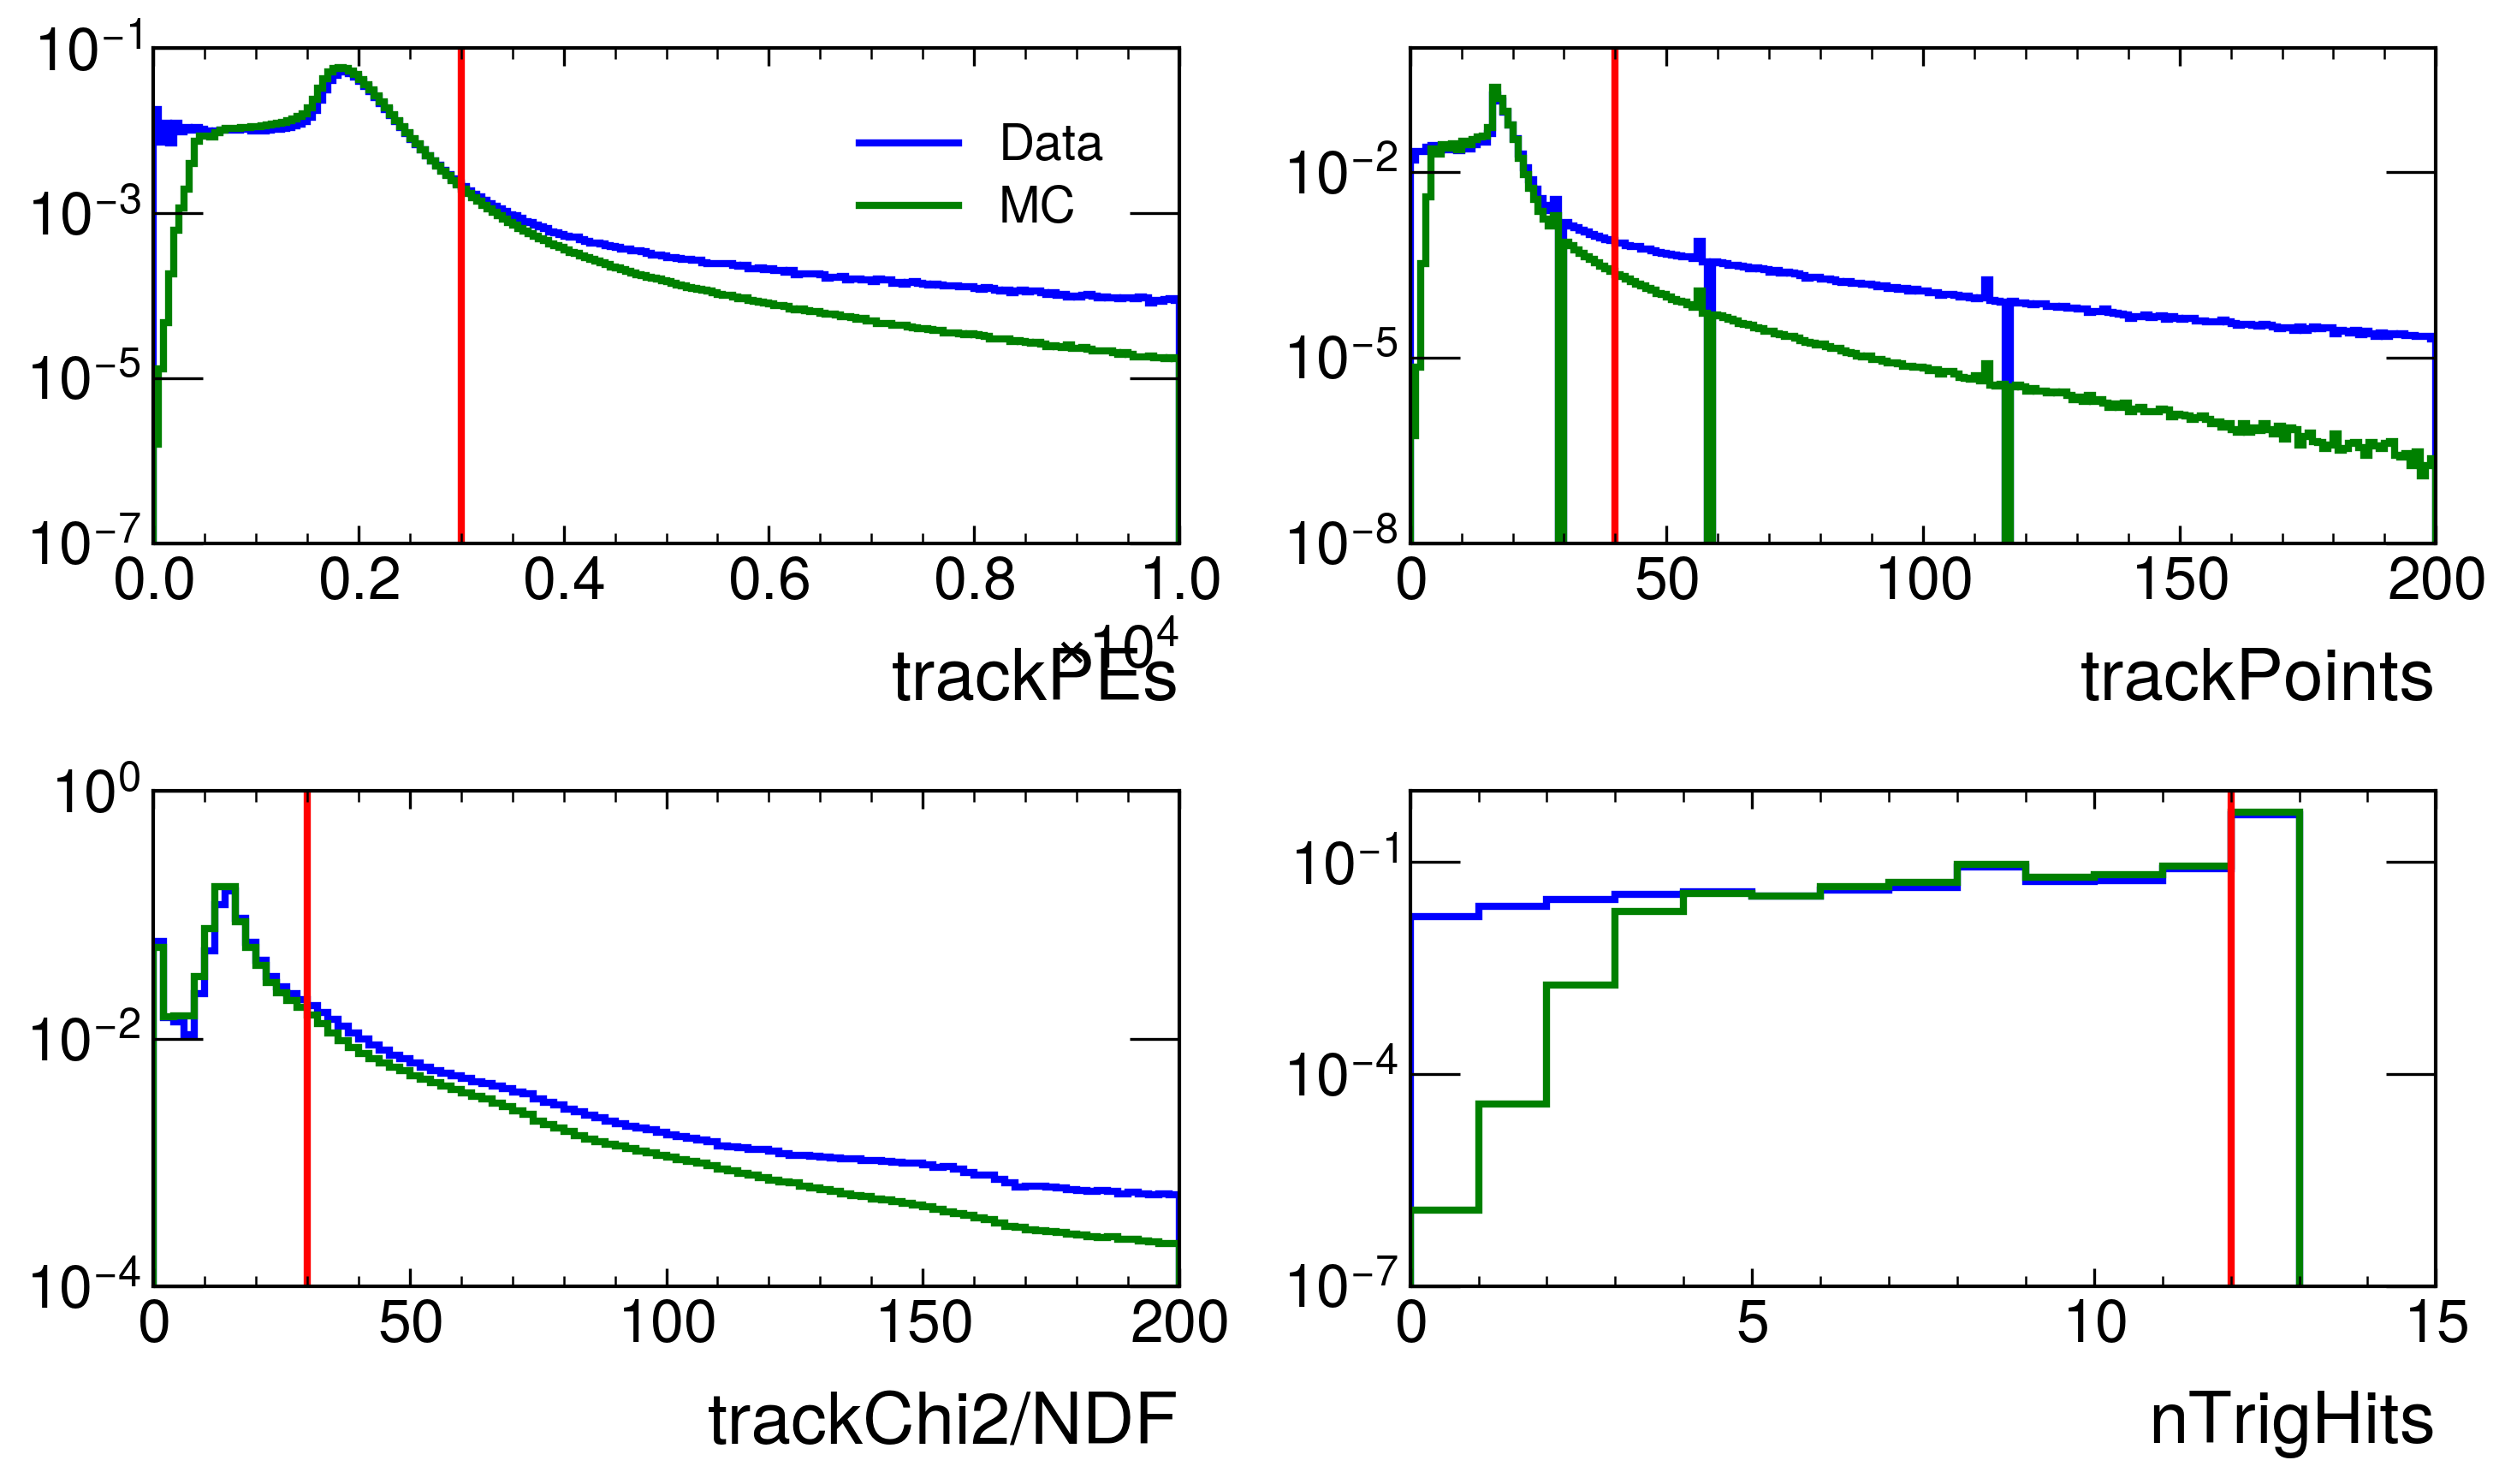

In [38]:
hTrackPEsDataUncutNorm = hTrackPEsDataUncut/hTrackPEsDataUncut.sum()
hTrackPointsDataUncutNorm = hTrackPointsDataUncut/hTrackPointsDataUncut.sum()
hTrackChi2DataUncutNorm = hTrackChi2DataUncut/hTrackChi2DataUncut.sum()
hTrigHitsDataUncutNorm = hTrigHitsDataUncut/hTrigHitsDataUncut.sum()

hTrackPEsMCUncutNorm = hTrackPEsMCUncut/hTrackPEsMCUncut.sum()
hTrackPointsMCUncutNorm = hTrackPointsMCUncut/hTrackPointsMCUncut.sum()
hTrackChi2MCUncutNorm = hTrackChi2MCUncut/hTrackChi2MCUncut.sum()
hTrigHitsMCUncutNorm = hTrigHitsMCUncut/hTrigHitsMCUncut.sum()

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2)
hTrackPEsDataUncutNorm.plot1d(linewidth=2.0, ax=ax0, color='blue', label='Data')
hTrackPointsDataUncutNorm.plot1d(linewidth=2.0, ax=ax1, color='blue')
hTrackChi2DataUncutNorm.plot1d(linewidth=2.0, ax=ax2, color='blue')
hTrigHitsDataUncutNorm.plot1d(linewidth=2.0, ax=ax3, color='blue')

hTrackPEsMCUncutNorm.plot1d(linewidth=2.0, ax=ax0, color='green', label='MC')
hTrackPointsMCUncutNorm.plot1d(linewidth=2.0, ax=ax1, color='green')
hTrackChi2MCUncutNorm.plot1d(linewidth=2.0, ax=ax2, color='green')
hTrigHitsMCUncutNorm.plot1d(linewidth=2.0, ax=ax3, color='green')

ax0.axvline(x=3000, ymin=0, ymax=1, color='r')
ax1.axvline(x=40, ymin=0, ymax=1, color='r')
ax2.axvline(x=30, ymin=0, ymax=1, color='r')
ax3.axvline(x=12, ymin=0, ymax=1, color='r')

#ax.set_xlabel('PEs in layer')
ax0.set_yscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')

ax0.legend()

ax2.set_xlabel('trackChi2/NDF')

fig.set_figheight(6)
fig.set_figwidth(10)
fig.tight_layout()

plt.show()

In [17]:
def GetLightYield(ar_skim_list):
    #h = Hist(hist.axis.Regular(bins=300, start=0, stop=300, name="light yield"))
    h = Hist(hist.axis.Regular(bins=60, start=0, stop=300, name="light yield", flow=False))
    for i in range(len(ar_skim_list)):
        ar_clean = ar_skim_list[i]
        
        h.fill(ar_clean["PEsTestLayer1"])
        h.fill(ar_clean["PEsTestLayer2"])
        h.fill(ar_clean["PEsTestLayer3"])
        h.fill(ar_clean["PEsTestLayer4"])
        
    return h

In [133]:
def GetLightYieldPerHit(ar_skim_list):
    #h = Hist(hist.axis.Regular(bins=300, start=0, stop=300, name="light yield"))
    h = Hist(hist.axis.Regular(bins=60, start=0, stop=300, name="light yield per hit", flow=False))
    for i in range(len(ar_skim_list)):
        ar_clean = ar_skim_list[i]

        h.fill(ar_clean["trackPEs"]/ar_clean["trackPoints"])
        
    return h

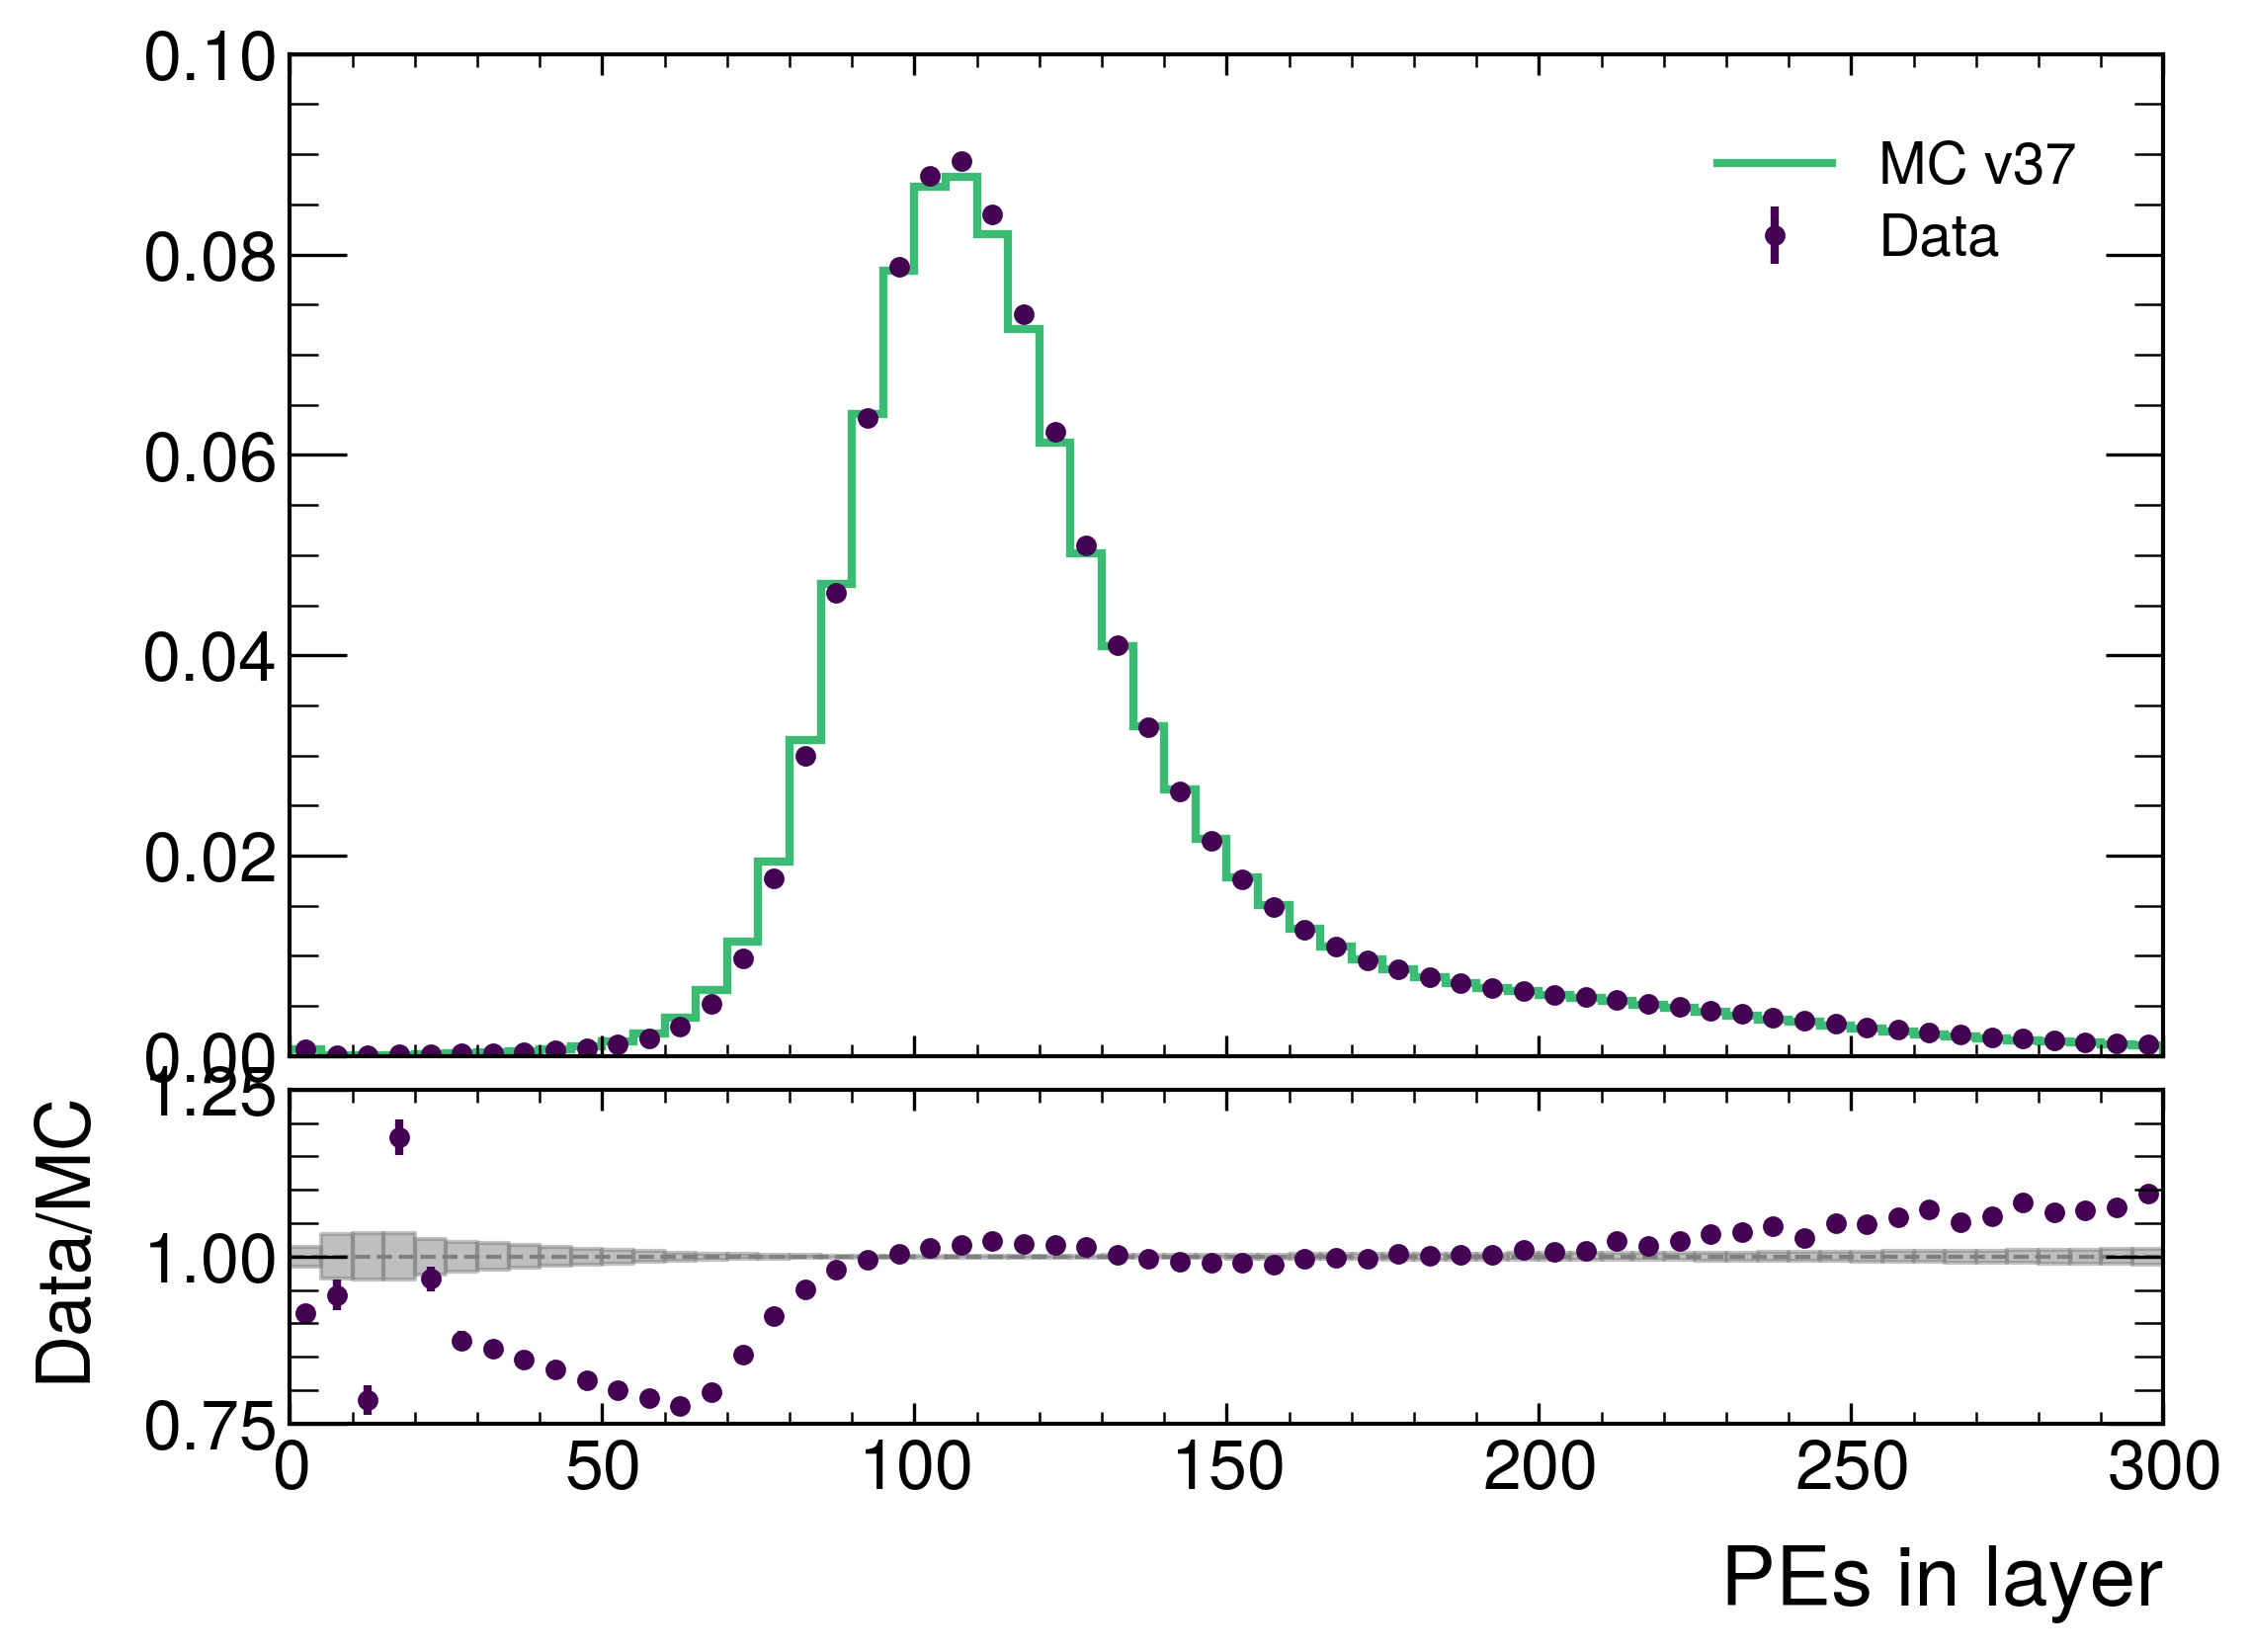

In [176]:
hMC = GetLightYield(ar_skim_list_MC)
hData = GetLightYield(ar_skim_list_data)

hMC_norm = hMC/hMC.sum()
hData_norm = hData/hData.sum()

hData_norm_error = np.sqrt(hData)/hData.sum()

hMC_norm_error = np.sqrt(hMC)/hMC.sum()
hMC_norm_error_high = hMC_norm+hMC_norm_error
hMC_norm_error_low = hMC_norm-hMC_norm_error

LYratio = hData_norm/hMC_norm
LYratio_error = hData_norm_error/hMC_norm

hMCratio_error_high = hMC_norm_error_high/hMC_norm
hMCratio_error_low = hMC_norm_error_low/hMC_norm

bin_edges = hData_norm.axes[0].edges
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05})

ax[0].stairs(hMC_norm.values(), bin_edges, label="MC v37", color="#3CBB75FF", linewidth=2)
for i in range(len(bin_edges)-1):
    ax[0].fill_between([bin_edges[i],bin_edges[i+1]], [hMC_norm_error_high[i],hMC_norm_error_high[i]], [hMC_norm_error_low[i],hMC_norm_error_low[i]], color='#3CBB75FF', alpha=0.5)
ax[0].errorbar(bin_centers, hData_norm.values(), yerr=hData_norm_error, fmt='.', color="#440154FF", label="Data")
ax[0].legend()
ax[0].set_ylim(0, 0.1)

ax[1].errorbar(bin_centers, LYratio.values(), yerr=LYratio_error, fmt='.', color="#440154FF")
ax[1].axhline(1, color='gray', linestyle='--', linewidth=1)
for i in range(len(bin_edges)-1):
    ax[1].fill_between([bin_edges[i],bin_edges[i+1]], [hMCratio_error_high[i],hMCratio_error_high[i]], [hMCratio_error_low[i],hMCratio_error_low[i]], color='gray', alpha=0.5)
ax[1].set_ylim(0.75, 1.25)

ax[0].set_xlim(0,300)
ax[1].set_xlim(0,300)

ax[1].set_xlabel('PEs in layer')
ax[1].set_ylabel('Data/MC', fontsize=18)

#fig.savefig('/exp/mu2e/data/users/thoroho/lightyield_ratio.pdf',dpi=300)

plt.show()

In [36]:
def GetTrackSlope(ar_skim_list, MC=True):
    h = Hist(hist.axis.Regular(bins=100, start=-0.5, stop=0.5, name="Track slope", flow=False))
    for i in range(len(ar_skim_list)):
        ar_clean = ar_skim_list[i]
        if not MC:
            h.fill(ar_clean['trackSlope'])
        else:
            h.fill(ar_clean['trackSlope'][:,0])

    return h

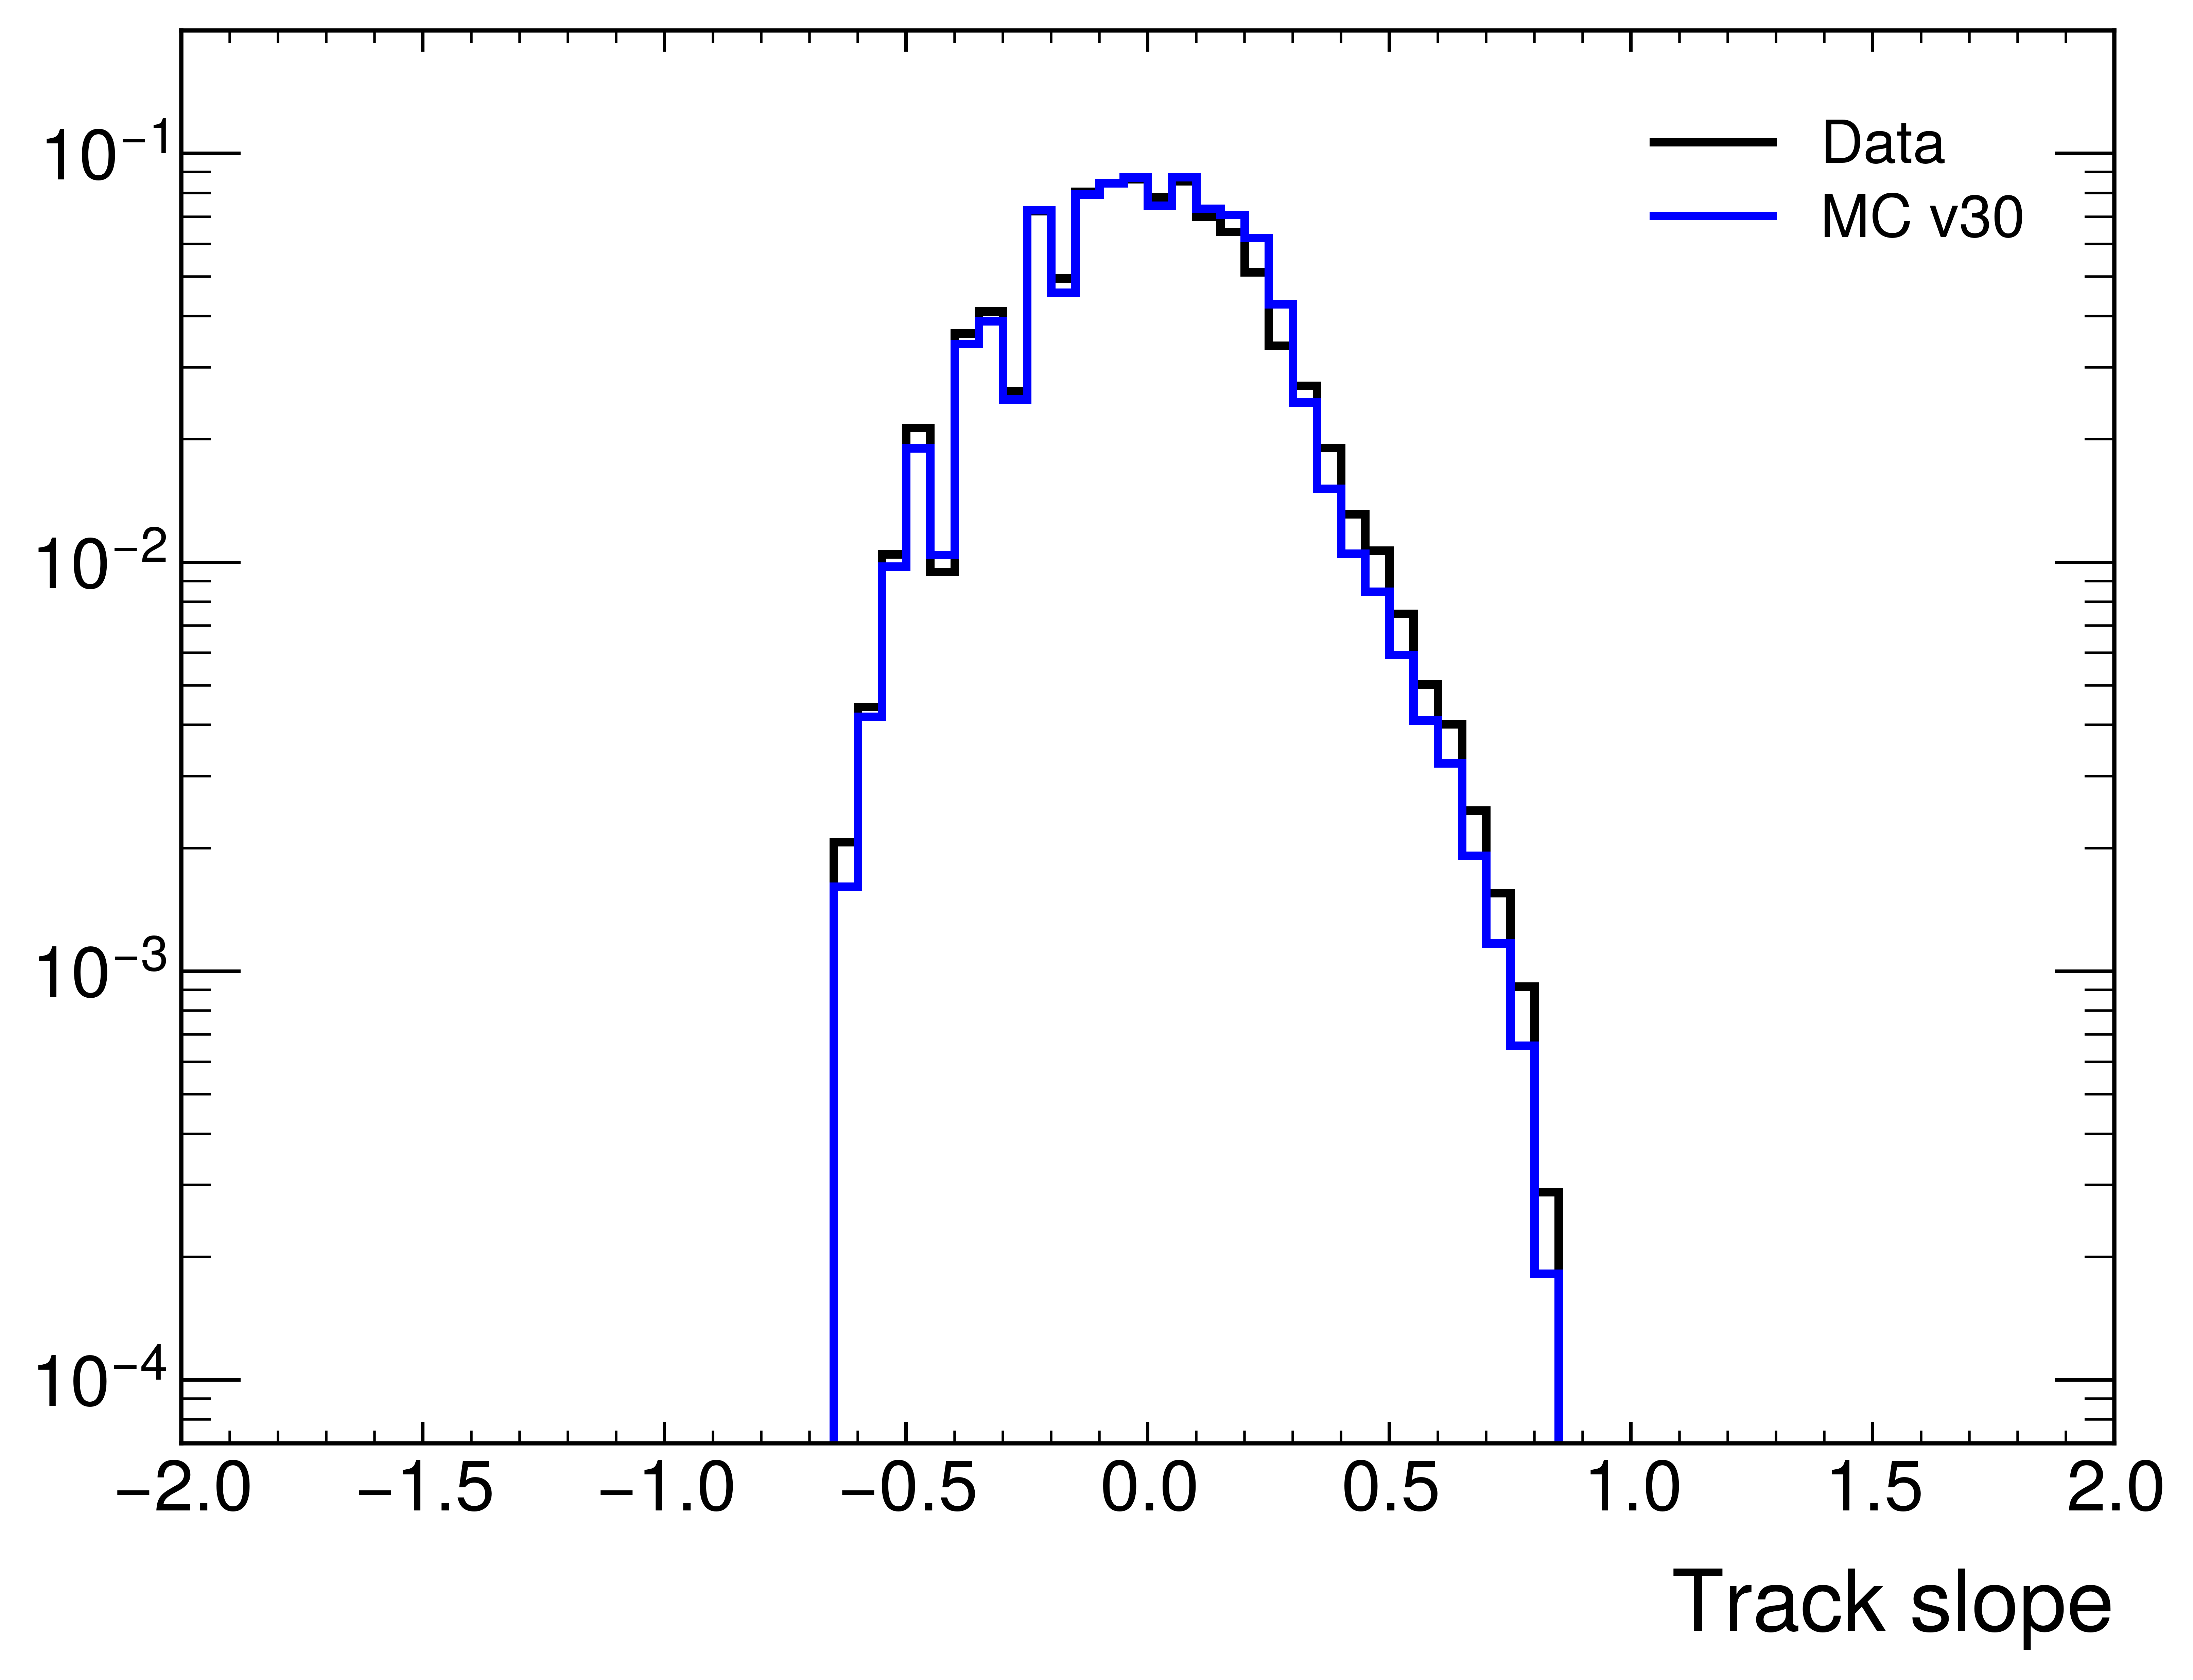

In [40]:
hTrackSlopeData_norm = hTrackSlopeData/hTrackSlopeData.sum()
hTrackSlopeMC_norm = hTrackSlopeMC/hTrackSlopeMC.sum()

fig, ax = plt.subplots()
hTrackSlopeData_norm.plot1d(label='Data', color = 'black', linewidth=2.0)
hTrackSlopeMC_norm.plot1d(label='MC v30', color = 'blue', linewidth=2.0)
ax.legend()
ax.set_xlabel('Track slope')
ax.set_yscale('log')
ax.set_xlim(-2,2)
ax.set_ylim(7e-5, 0.2)
plt.show()

In [15]:
ineff_extrapolated_data = [5.80619416e-06, 7.24190883e-06, 9.84454203e-06, 1.39584470e-05,
                           2.07129148e-05, 3.08754852e-05, 4.64224524e-05, 7.21148195e-05,
                           1.15809772e-04, 1.92459630e-04, 3.40664664e-04, 6.54086856e-04,
                           1.42825341e-03, 3.57803058e-03, 9.81134249e-03, 2.68443264e-02,
                           6.73952210e-02, 1.46978799e-01, 2.71909725e-01, 4.27622432e-01,
                           5.85162031e-01, 7.18608331e-01, 8.16673081e-01, 8.82137579e-01, 9.23500312e-01]
ineff_3of4_data = [4.05736940e-06, 4.50818822e-06, 4.50818822e-06, 4.50818822e-06, 4.50818822e-06,
                   4.50818822e-06, 4.50818822e-06, 4.95900704e-06, 4.95900704e-06, 1.08196517e-05,
                   3.65163246e-05, 1.80327529e-04, 8.18236162e-04, 3.13499409e-03, 1.02245709e-02,
                   2.94443297e-02, 7.35096155e-02, 1.56029747e-01, 2.80152341e-01, 4.29847181e-01,
                   5.78556532e-01, 7.03741255e-01, 7.96366490e-01, 8.59270142e-01, 8.99913713e-01]
error_3of4_data = [1.35245372e-06, 1.42561108e-06, 1.42561108e-06, 1.42561108e-06, 1.42561108e-06,
                   1.42561108e-06, 1.42561108e-06, 1.49519317e-06, 1.49519317e-06, 2.20854021e-06,
                   4.05729532e-06, 9.01556346e-06, 1.91982925e-05, 3.75350984e-05, 6.75447968e-05,
                   1.13504239e-04, 1.75223985e-04, 2.43651053e-04, 3.01521612e-04, 3.32394401e-04,
                   3.31545841e-04, 3.06579502e-04, 2.70384712e-04, 2.33485011e-04, 2.01506353e-04]

In [31]:
ineff_3of4_MC = [0.0000022539339047348027, 0.0000023315624847200412, 0.0000023315624847200412,
                 0.0000025808615404180874, 0.000002669749957287944, 0.0000027616998133438605,
                 0.000002856816548757008, 0.0000032711908469136857, 0.000005817091329374394,
                 0.000030569907009353906, 0.00016618362775387533, 0.000737304795871685,
                 0.002669749957287939, 0.008161400793251844, 0.022539339047347933,
                 0.05623413251903497, 0.11844845812380062, 0.22539339047347923,
                 0.36209583502459186, 0.508021804691302, 0.6224688843995442, 0.7373047958716825,
                 0.8161400793251828, 0.8733261623828431, 0.9034047151333574]
ineff_extrapolated_MC = [0.000004589492937486822, 0.0000060174399458955516, 0.000007889669729459848,
                         0.000011450475699382882, 0.000017190722018585815, 0.000027616998133438604, 
                         0.00004436687330978634, 0.00007373047958716864, 0.00012674801788800243,
                         0.00024118646996410046, 0.0004747561378997435, 0.0010700689556931778,
                         0.002669749957287939, 0.00689025498729723, 0.01839525795803975,
                         0.045894929374868054, 0.10344413737342371, 0.2036214517136351,
                         0.3383855153428235, 0.4911073914777702, 0.6439075678850823,
                         0.7626985859023444, 0.844249064816711, 0.9034047151333574, 0.9345192145605372]